# Install Library, Santiment

In [ ]:
pip install san

  Preparing metadata (setup.py) ... done
  Created wheel for san: filename=san-1.2.0-py3-none-any.whl size=1198 sha256=294a5e2871f02c204f16caa2639f1cf21f375175fb35b330d68d7dea3d93bee8
  Stored in directory: /root/.cache/pip/wheels/7e/6f/a7/0ad94e2596aa6c730302a321d06ed4a8e4a4d98a19a6e02ebd
Successfully built san


In [ ]:
pip install sanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
pip install --upgrade sanpy

In [ ]:
import san
san.ApiConfig.api_key = "43equtgkz2xgzh7s_4fuho7lcokjpwvfv"

# New Model

## Step 1(Data Acquisition)

✅ Step 1: Data Fetching
Function: fetch_multiple_tokens_data_with_sentiment

🔍 Purpose:
To collect and merge key time-series data (price, sentiment, social, dev activity, whale data) for multiple tokens across the last 2 years.

📌 What it does:
* Loops through a list of tokens.

* For each token:
  * Fetches daily data from Santiment:
    * price_usd
    * social_volume_total
    * sentiment_weighted_total, positive, negative, balance
    * dev_activity
  * Merges each metric into one combined DataFrame.
  * Adds whale-related metrics from external sources:
    * amount_in_top_holders
    * whale_transaction_count
    * whale_transaction_volume

* Stores final merged DataFrame in all_tokens_data[token].

🧠 Why it matters:
This step builds the raw dataset that powers all future steps — ensuring each token has consistent, aligned, and enriched data for training and evaluation.

In [ ]:
# Main function to fetch and merge data
def fetch_multiple_tokens_data_with_sentiment(tokens, df_top_holders, df_whale_count, df_whale_volume):
    yesterday = datetime.today() - timedelta(1)
    two_years_back = datetime.today() - timedelta(365 * 2)

    from_date = two_years_back.strftime('%Y-%m-%d')
    to_date = yesterday.strftime('%Y-%m-%d')

    all_tokens_data = {}

    for token in tokens:
        print(f"Fetching data for {token}...")

        def df_with_metric_name(raw_data, column_name):
            df = pd.DataFrame(raw_data)
            if 'value' in df.columns:
                df = df.rename(columns={'value': column_name})
            return df

        df_price = df_with_metric_name(
            san.get("price_usd", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "price_usd"
        )
        df_social = df_with_metric_name(
            san.get("social_volume_total", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "social_volume_total"
        )
        df_sentiment_weighted = df_with_metric_name(
            san.get("sentiment_weighted_total", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "sentiment_weighted_total"
        )
        df_positive = df_with_metric_name(
            san.get("sentiment_positive_total", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "sentiment_positive_total"
        )
        df_negative = df_with_metric_name(
            san.get("sentiment_negative_total", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "sentiment_negative_total"
        )
        df_balance = df_with_metric_name(
            san.get("sentiment_balance_total", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "sentiment_balance_total"
        )
        df_dev = df_with_metric_name(
            san.get("dev_activity", slug=token, from_date=from_date, to_date=to_date, interval="1d"),
            "dev_activity"
        )

        combined_df = df_price
        for df in [df_social, df_sentiment_weighted, df_positive, df_negative, df_balance, df_dev]:
            combined_df = pd.merge(combined_df, df, on='datetime', how='inner')

        # Merge Top Holders
        top_holder_col = f"{token}_amount_in_top_holders"
        if top_holder_col in df_top_holders.columns:
            df_holder = df_top_holders[["datetime", top_holder_col]].rename(columns={top_holder_col: "amount_in_top_holders"})
            combined_df = pd.merge(combined_df, df_holder, on="datetime", how="inner")

        # Merge Whale Count
        count_col = f"{token}_whale_transaction_count_100k_usd_to_inf"
        if count_col in df_whale_count.columns:
            df_count = df_whale_count[["datetime", count_col]].rename(columns={count_col: "whale_tx_count"})
            combined_df = pd.merge(combined_df, df_count, on="datetime", how="inner")

        # Merge Whale Volume
        volume_col = f"{token}_whale_transaction_volume_100k_usd_to_inf"
        if volume_col in df_whale_volume.columns:
            df_volume = df_whale_volume[["datetime", volume_col]].rename(columns={volume_col: "whale_tx_volume"})
            combined_df = pd.merge(combined_df, df_volume, on="datetime", how="inner")

        all_tokens_data[token] = combined_df

    return all_tokens_data

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Load your custom CSVs
df_top_holders = pd.read_csv('/content/amount_in_top_holders.csv')
df_whale_transactions_count = pd.read_csv('/content/whale_transaction_count_100k_usd_to_inf.csv')
df_whale_transactions_volume = pd.read_csv('/content/whale_transaction_volume_100k_usd_to_inf.csv')

# Convert datetime columns to UTC
for df in [df_top_holders, df_whale_transactions_count, df_whale_transactions_volume]:
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

#Define common DeFi tokens
# tokens = [
#     # 🟦 DeFi Blue Chips
#     "aave", "uniswap", "sushi", "maker", "yearn-finance", "balancer", "bancor",

#     # 🟩 Staking & Stablecoins
#     "lido-dao", "rocket-pool", "frax", "frax-share", "liquity", "liquity-usd",
#     "magic-internet-money",

#     # 🟧 Infrastructure & Oracles
#     "chainlink", "api3", "tellor", "uma", "injective-protocol", "dydx",

#     # 🟨 Yield & Aggregators
#     "convex-finance", "harvest-finance", "clearpool", "ondo-finance", "stargate-finance",

#     # 🟪 Liquidity Protocols
#     "loopring", "badger-dao", "0x", "1inch",

#     # 🟥 Niche Projects / Others
#     "ampleforth", "hashflow", "orbs", "numeraire"
# ]

tokens = [
    "aave", "uniswap", "sushi", "maker",  # DeFi blue chips
    "lido-dao", "frax", "frax-share", "rocket-pool",         # ETH staking / stable
    "chainlink", "dydx", "convex-finance", "injective-protocol",  # Active infra
    "balancer", "loopring", "badger-dao"                     # Liquidity-focused
]

# Run the function
all_tokens_data = fetch_multiple_tokens_data_with_sentiment(
    tokens,
    df_top_holders,
    df_whale_transactions_count,
    df_whale_transactions_volume
)


Fetching data for aave...
Fetching data for uniswap...
Fetching data for sushi...
Fetching data for maker...
Fetching data for lido-dao...
Fetching data for frax...
Fetching data for frax-share...
Fetching data for rocket-pool...
Fetching data for chainlink...
Fetching data for dydx...
Fetching data for convex-finance...
Fetching data for injective-protocol...
Fetching data for balancer...
Fetching data for loopring...
Fetching data for badger-dao...


## Step 2(Feature Engineering)

✅ Step 2: Feature Engineering
Function: analyze_multiple_tokens_data_with_sentiment

🔍 Purpose:
To transform raw token data into engineered features that capture return patterns, sentiment dynamics, whale movements, and anomalies — all essential for predictive modeling and signal generation.

📌 What it does:
*   Return features:
  * Daily return: % change in price_usd
  * Future return (1-day ahead): shift(-1) of return
  * Weekly return: % change over 7 days
* Social trend feature:
  * 7-day rolling average of social volume
* Z-score standardization:
  * Normalizes metrics like:
    * social_volume_total
    * sentiment_weighted_total
    * dev_activity
    * amount_in_top_holders
    * whale_tx_count
    * whale_tx_volume
* Whale accumulation behavior:
  * Computes delta_top_holders (day-over-day change in whale holdings)
* Feature interaction:
  * sentiment × volume — useful for capturing coordinated crowd behavior
* Signal labeling logic:
  * Buy signal: High social buzz, positive sentiment, whale accumulation
  * Sell signal: Drop in volume/sentiment, price down, whale distribution
  * Default signal: 'hold'
* Anomaly flags:
  * Flags extreme z-scores (>|2|) across social, sentiment, whale metrics

🧠 Why it matters:
This step turns raw market/sentiment data into model-ready features and labels, laying the groundwork for signal evaluation, statistical validation, and machine learning.

In [ ]:
from scipy.stats import zscore
import pandas as pd

def analyze_multiple_tokens_data_with_sentiment(all_tokens_data):
    all_tokens_analysis = {}

    for token, combined_df in all_tokens_data.items():
        print(f"Processing data for {token}...")

        # --- Return features ---
        combined_df['return'] = combined_df['price_usd'].pct_change() * 100
        combined_df['future_return_1d'] = combined_df['return'].shift(-1)
        combined_df['rolling_return_7d'] = combined_df['price_usd'].pct_change(periods=7) * 100

        # --- Social trend ---
        combined_df['rolling_avg'] = combined_df['social_volume_total'].rolling(window=7).mean()

        # --- Z-Score normalization (standardization) ---
        combined_df['z_social_volume'] = zscore(combined_df['social_volume_total'].fillna(0))
        combined_df['z_sentiment_weighted'] = zscore(combined_df['sentiment_weighted_total'].fillna(0))
        combined_df['z_dev_activity'] = zscore(combined_df['dev_activity'].fillna(0))
        combined_df['z_amount_in_top_holders'] = zscore(combined_df['amount_in_top_holders'].fillna(0))
        combined_df['z_whale_tx_count'] = zscore(combined_df['whale_tx_count'].fillna(0))
        combined_df['z_whale_tx_volume'] = zscore(combined_df['whale_tx_volume'].fillna(0))

        # --- Whale movement (accumulation/distribution) ---
        combined_df['delta_top_holders'] = combined_df['amount_in_top_holders'].diff()

        # --- Feature interaction (optional) ---
        combined_df['sentiment_x_volume'] = (
            combined_df['sentiment_weighted_total'] * combined_df['social_volume_total']
        )

        # --- Base signal ---
        combined_df['signal'] = 'hold'

        # --- Buy condition: social + sentiment + whales accumulating ---
        buy_condition = (
            (combined_df['social_volume_total'] > combined_df['rolling_avg'] * 1.5) &
            (combined_df['sentiment_weighted_total'] > 0) &
            (combined_df['delta_top_holders'] > 0) &
            (combined_df['z_whale_tx_count'] > 1.5)
        )

        # --- Sell condition: opposite pattern + whale distribution ---
        sell_condition = (
            (combined_df['social_volume_total'] < combined_df['rolling_avg']) &
            (combined_df['sentiment_weighted_total'] < 0) &
            (combined_df['delta_top_holders'] < 0) &
            (combined_df['return'] < 0) &
            (combined_df['z_whale_tx_volume'] > 2)
        )

        # --- Assign signals ---
        combined_df.loc[buy_condition, 'signal'] = 'buy'
        combined_df.loc[sell_condition, 'signal'] = 'sell'

        # --- Anomaly flags ---
        combined_df['anomaly_social'] = combined_df['z_social_volume'].abs() > 2
        combined_df['anomaly_sentiment'] = combined_df['z_sentiment_weighted'].abs() > 2
        combined_df['anomaly_whale_volume'] = combined_df['z_whale_tx_volume'].abs() > 2
        combined_df['anomaly_whale_count'] = combined_df['z_whale_tx_count'].abs() > 2

        # --- Cleanup ---
        combined_df.dropna(inplace=True)
        combined_df.reset_index(drop=True, inplace=True)

        all_tokens_analysis[token] = combined_df

    return all_tokens_analysis


In [ ]:
all_tokens_analysis = analyze_multiple_tokens_data_with_sentiment(all_tokens_data)

Processing data for aave...
Processing data for uniswap...
Processing data for sushi...
Processing data for maker...
Processing data for lido-dao...
Processing data for frax...
Processing data for frax-share...
Processing data for rocket-pool...
Processing data for chainlink...
Processing data for dydx...
Processing data for convex-finance...
Processing data for injective-protocol...
Processing data for balancer...
Processing data for loopring...
Processing data for badger-dao...


## Step 3 (Cross-Sectional Validation)

✅ Step 3: Factor Validation via IC + Quantile Analysis
Function: validate_multiple_factors_cross_sectionally

🔍 Purpose:
To assess how predictive each factor is across tokens using two techniques:
* Information Coefficient (IC) — for correlation
* Quantile Return Analysis — for ranking power

Evaluate each factor’s predictive power across tokens by computing:
* IC (Information Coefficient): Spearman rank correlation between factor values and future_return_1d
* Quantile Returns: Average returns of tokens grouped by factor percentile (Q1 = lowest, Q5 = highest)

📌 What it does:
* Iterates through each candidate factor (e.g., z-scores, lagged metrics)
* Per date, ranks tokens by that factor and:
  * Calculates Spearman rank correlation (IC) between factor and next-day return
  * Splits tokens into quantiles (e.g., top 20% = Q5, bottom 20% = Q1)
  * Tracks the average return for each quantile
* For each factor, returns:
  * Mean IC: avg. rank correlation between factor & return
  * ICIR: information coefficient information ratio (mean / std)
  * Average return per quantile (Q1 to Q5)

🧠 Why it matters:
This step objectively tests factor quality before training:
* A good factor should show monotonic return spread across quantiles
* And a positive/negative consistent IC
* Helps you identify which features are worth training the ML model on



In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# ✅ Updated Agent: Cross-token validation for multiple factors
def validate_multiple_factors_cross_sectionally(df, factor_cols, return_col, n_quantiles=5):
    """
    Validate multiple factors using cross-token ranking (IC + quantile returns).

    Parameters:
        df: Combined DataFrame (must contain 'datetime', 'token', factor columns, and return column)
        factor_cols: list of str, factor column names
        return_col: str, return column name (e.g., 'future_return_1d')
        n_quantiles: int, number of quantile buckets

    Returns:
        result_summary: list of dictionaries with results per factor
        all_ic_series: dict of factor -> IC time series (pandas.Series)
    """
    df = df.dropna(subset=[return_col])
    results = []
    all_ic_series = {}

    for factor_col in factor_cols:
        df_factor = df.dropna(subset=[factor_col])
        ic_list = []
        ic_dates = []
        quantile_returns = {f'Q{i+1}': [] for i in range(n_quantiles)}

        for date, group in df_factor.groupby('datetime'):
            try:
                group_sorted = group.sort_values(by=factor_col)
                group_sorted['quantile'] = pd.qcut(group_sorted[factor_col], n_quantiles, labels=False)
            except ValueError:
                continue

            if group_sorted[factor_col].nunique() > 1 and group_sorted[return_col].nunique() > 1:
                ic, _ = spearmanr(group_sorted[factor_col], group_sorted[return_col])
                ic_list.append(ic)
                ic_dates.append(date)

            for q in range(n_quantiles):
                q_label = f'Q{q+1}'
                avg_return = group_sorted[group_sorted['quantile'] == q][return_col].mean()
                if not np.isnan(avg_return):
                    quantile_returns[q_label].append(avg_return)

        quantile_avg = {q: np.mean(r) for q, r in quantile_returns.items() if len(r) > 0}
        ic_series = pd.Series(ic_list, index=pd.to_datetime(ic_dates))
        all_ic_series[factor_col] = ic_series

        result_row = {
            'factor': factor_col,
            'mean_ic': ic_series.mean(),
            'std_ic': ic_series.std(),
            'icir': ic_series.mean() / ic_series.std() if ic_series.std() != 0 else np.nan
        }
        for q, avg_ret in quantile_avg.items():
            result_row[f'avg_return_{q}'] = avg_ret
        results.append(result_row)

    summary_df = pd.DataFrame(results)


    return summary_df, all_ic_series


In [ ]:
combined_df = pd.concat([df.assign(token=token) for token, df in all_tokens_analysis.items()])
factor_cols = ['z_sentiment_weighted',
               'z_whale_tx_count',
               'z_amount_in_top_holders',
               'z_social_volume',
               'z_whale_tx_volume',
               'z_dev_activity',
               'delta_top_holders',
               'sentiment_x_volume']

return_col = 'future_return_1d'

summary_df, all_ic_series = validate_multiple_factors_cross_sectionally(
    combined_df,
    factor_cols=factor_cols,
    return_col=return_col
)


In [ ]:
summary_df

,factor,mean_ic,std_ic,icir,avg_return_Q1,avg_return_Q2,avg_return_Q3,avg_return_Q4,avg_return_Q5
0,z_sentiment_weighted,0.007193,0.281115,0.025588,0.029540,0.015134,0.053789,0.204757,0.149945
1,z_whale_tx_count,-0.034774,0.284950,-0.122037,0.111104,0.164114,0.087987,0.122242,-0.054184
2,z_amount_in_top_holders,0.002643,0.272260,0.009707,0.004331,0.199425,0.028657,0.047714,0.152388
3,z_social_volume,-0.008781,0.281094,-0.031240,0.107363,0.049672,0.139897,-0.012161,0.141014
4,z_whale_tx_volume,-0.047616,0.277061,-0.171860,0.189797,0.161801,0.194572,0.008247,-0.119673
5,z_dev_activity,0.004322,0.271706,0.015905,0.184298,-0.071401,0.184326,0.073820,0.050818
6,delta_top_holders,0.015978,0.272697,0.058592,-0.023984,0.065921,0.134657,0.192739,0.072460
7,sentiment_x_volume,0.021361,0.280114,0.076257,0.353070,0.179308,0.265029,0.521122,0.273331


| Column               | Description                                        |
| -------------------- | -------------------------------------------------- |
| `factor`             | Factor being tested (e.g., `z_sentiment_weighted`) |
| `mean_ic`            | Average Spearman correlation with future returns   |
| `std_ic`             | Standard deviation of IC over time                 |
| `icir`               | Information Ratio = mean\_ic / std\_ic             |
| `avg_return_Q1`–`Q5` | Mean return in each factor quantile group          |


🧠 Interpretation Guide:
* High mean_ic → stronger correlation with future return
* High icir (> 0.1) → more stable and reliable factor
* Increasing avg_return_Q1 to Q5 → better rank discrimination (Q5 should outperform Q1)

Factor: z_amount_in_top_holders
- mean_ic: 0.0021 → weak rank correlation
- icir: 0.0079 → unstable signal
- Q1 to Q5 return: +0.012 → +0.162 → decent quantile return spread
=> Might be useful even with noisy IC.
Factor: z_whale_tx_volume
- mean_ic: -0.045 → inverse correlation
- Q5 return: negative → suggests top-ranked values underperform
=> Potential contrarian factor or noise.


In [ ]:
all_ic_series

{'z_sentiment_weighted': 2023-06-19 00:00:00+00:00    0.057143
 2023-06-20 00:00:00+00:00    0.007143
 2023-06-21 00:00:00+00:00    0.475000
 2023-06-22 00:00:00+00:00    0.225000
 2023-06-23 00:00:00+00:00   -0.350000
                                ...   
 2025-04-28 00:00:00+00:00    0.060714
 2025-04-29 00:00:00+00:00   -0.028571
 2025-04-30 00:00:00+00:00   -0.271429
 2025-05-01 00:00:00+00:00    0.285714
 2025-05-02 00:00:00+00:00   -0.017857
 Length: 684, dtype: float64,
 'z_whale_tx_count': 2023-06-19 00:00:00+00:00    0.289286
 2023-06-20 00:00:00+00:00   -0.196429
 2023-06-21 00:00:00+00:00   -0.303571
 2023-06-22 00:00:00+00:00   -0.239286
 2023-06-23 00:00:00+00:00    0.010714
                                ...   
 2025-04-28 00:00:00+00:00   -0.067857
 2025-04-29 00:00:00+00:00   -0.453571
 2025-04-30 00:00:00+00:00    0.100000
 2025-05-01 00:00:00+00:00    0.132143
 2025-05-02 00:00:00+00:00   -0.171429
 Length: 684, dtype: float64,
 'z_amount_in_top_holders': 2023-06-19

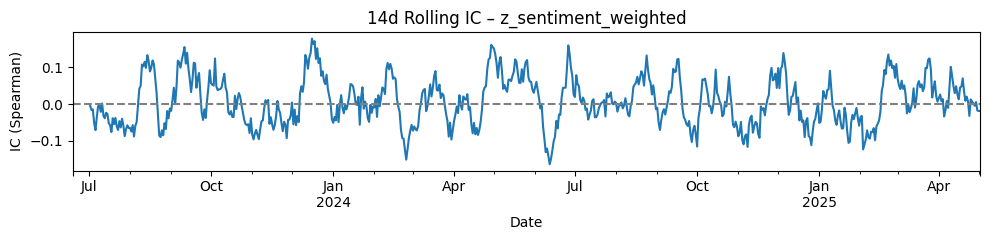

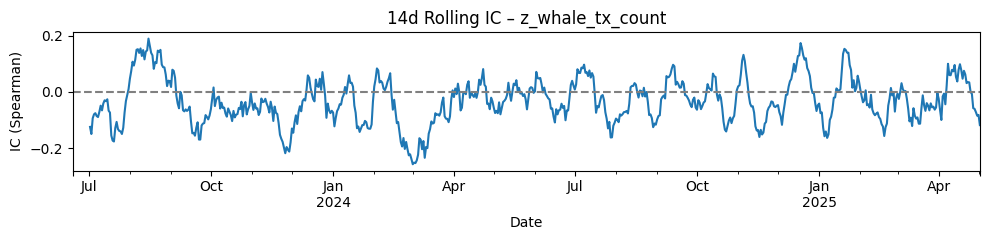

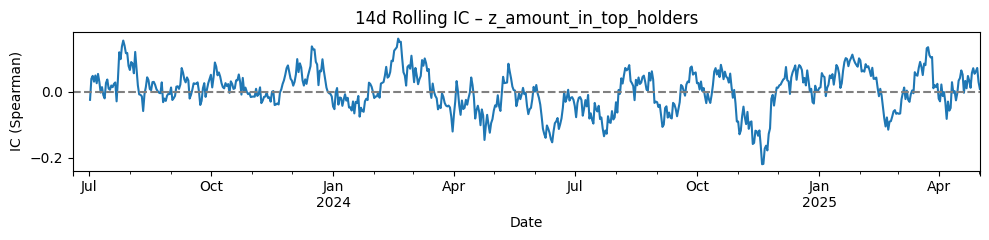

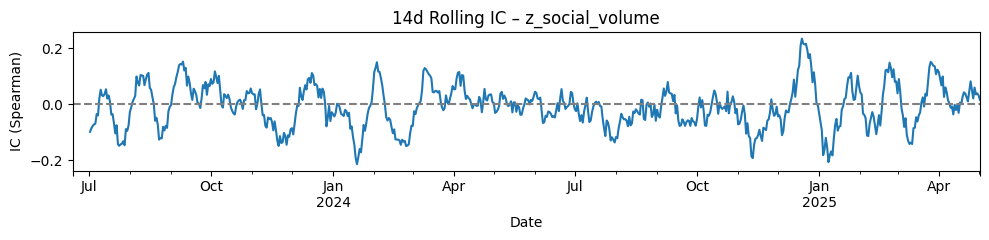

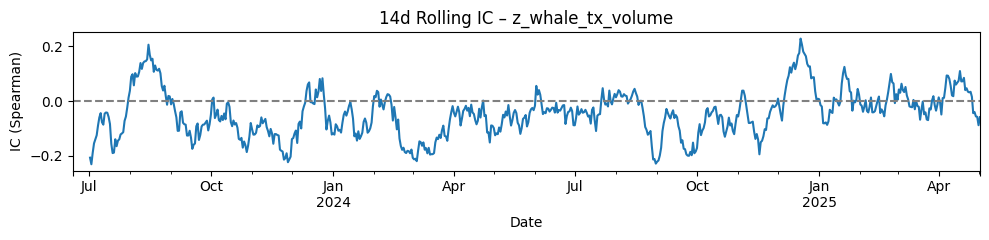

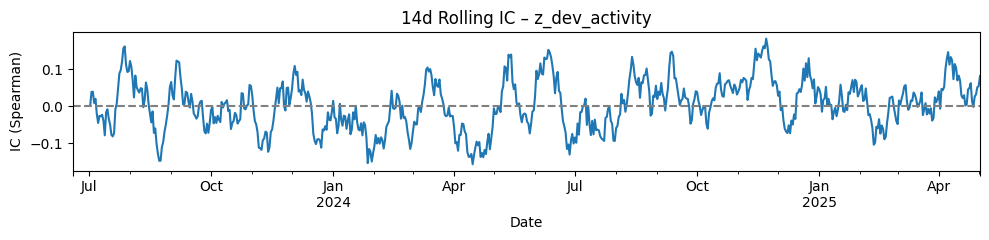

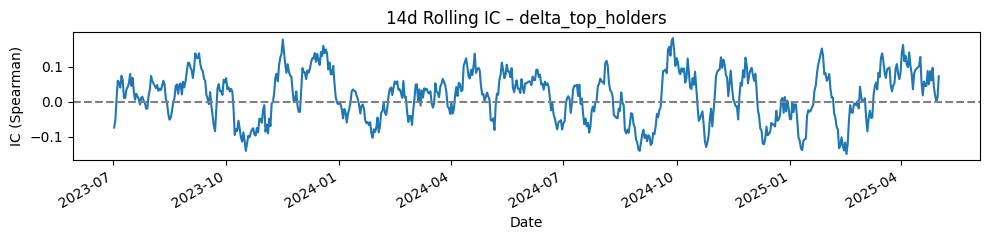

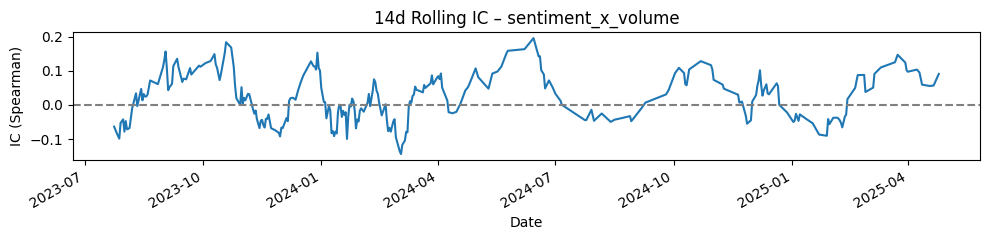

In [ ]:
import matplotlib.pyplot as plt

for factor, series in all_ic_series.items():
    smoothed = series.rolling(14).mean()
    smoothed.plot(figsize=(10, 2.5), title=f"14d Rolling IC – {factor}")
    plt.axhline(0, linestyle='--', color='gray')
    plt.ylabel("IC (Spearman)")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


You want to see:
* Positive and stable IC → shows consistent predictive power.
* ICIR > 0.1 → may be useful for alpha generation.
* Monotonic returns across quantiles (Q1 < ... < Q5) → good ranking behavior.

## Step 4 (Factor Significance Analysis)

✅ Step 4: Significance Testing via Lagged Regression
Function: run_lagged_regression_per_factor

🔍 Purpose:
To evaluate whether each individual factor is statistically predictive of future returns — on a per-token basis — using OLS regression.

📌 What it does:
* For every token and factor:
  * Shifts the target (future_return_1d) to align with the factor (i.e., predicts next-day return)

* Runs a linear regression:
  
  future_return_1d 𝑡+1 = 𝛼 + 𝛽 ⋅ factor 𝑡 + 𝜖

* Extracts and stores:
  * coefficient: the effect of the factor on next-day return
  * p_value: whether the effect is statistically significant
  * r_squared: how much variance the factor explains
  * t_value, n_obs: diagnostic stats
  * significant: whether p < 0.05

It skips tokens with insufficient data (<30 observations).

📈 Why it matters:

This step tells you which factors actually have predictive power — not just correlated signals. Specifically:

* A low p_value + consistent coefficient direction → trustworthy signal
* Helps you rank and filter features before ML training
* Highlights factors with spurious correlation (high IC but no statistical backing)



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 🧱 Agent: Run lagged regression per factor to evaluate predictive power
def run_lagged_regression_per_factor(df, common_tokens, factor_cols, return_col='future_return_1d', lag=1):
    all_results = []

    for factor_col in factor_cols:
        print(f"\nRunning lagged regression for factor: {factor_col}")

        for token in common_tokens:
            token_df = df[df['token'] == token][[factor_col, return_col]].copy()
            token_df['y'] = token_df[return_col].shift(-lag)  # future return
            token_df['X'] = token_df[factor_col]
            token_df = token_df.dropna()

            if len(token_df) < 30:
                continue  # not enough data

            X = sm.add_constant(token_df['X'])
            y = token_df['y']

            try:
                model = sm.OLS(y, X).fit()
                coef = model.params['X']
                pval = model.pvalues['X']
                r2 = model.rsquared
                tval = model.tvalues['X']
                nobs = model.nobs

                all_results.append({
                    'token': token,
                    'factor': factor_col,
                    'coefficient': coef,
                    'p_value': pval,
                    't_value': tval,
                    'r_squared': r2,
                    'n_obs': nobs,
                    'significant': pval < 0.05
                })
            except Exception as e:
                print(f"Regression failed for {token}: {e}")
                continue

    return pd.DataFrame(all_results)


In [ ]:
factor_cols = [
    'z_sentiment_weighted',
    'z_whale_tx_count',
    'z_amount_in_top_holders',
    'z_social_volume',
    'z_whale_tx_volume',
    'z_dev_activity',
    'delta_top_holders',
    'sentiment_x_volume'
]

common_tokens = combined_df['token'].unique()
regression_results = run_lagged_regression_per_factor(combined_df, common_tokens, factor_cols)



Running lagged regression for factor: z_sentiment_weighted

Running lagged regression for factor: z_whale_tx_count

Running lagged regression for factor: z_amount_in_top_holders

Running lagged regression for factor: z_social_volume

Running lagged regression for factor: z_whale_tx_volume

Running lagged regression for factor: z_dev_activity

Running lagged regression for factor: delta_top_holders

Running lagged regression for factor: sentiment_x_volume


In [ ]:
regression_results

,token,factor,coefficient,p_value,t_value,r_squared,n_obs,significant
0,aave,z_sentiment_weighted,0.027688,0.886131,0.143256,0.000030,678.0,False
1,uniswap,z_sentiment_weighted,0.104022,0.613992,0.504615,0.000374,683.0,False
2,sushi,z_sentiment_weighted,0.181402,0.436600,0.778411,0.000900,675.0,False
3,maker,z_sentiment_weighted,0.209873,0.247464,1.157523,0.001964,683.0,False
4,lido-dao,z_sentiment_weighted,0.264679,0.226266,1.211130,0.002152,682.0,False
...,...,...,...,...,...,...,...,...
115,convex-finance,sentiment_x_volume,0.156260,0.942343,0.072352,0.000008,670.0,False
116,injective-protocol,sentiment_x_volume,0.159862,0.027494,2.209190,0.007116,683.0,True
117,balancer,sentiment_x_volume,1.092036,0.034219,2.121816,0.006655,674.0,True
118,loopring,sentiment_x_volume,0.257160,0.564090,0.577064,0.000497,672.0,False


| Column        | Meaning                                                   |
| ------------- | --------------------------------------------------------- |
| `token`       | Which asset the test ran on (e.g., aave, sushi)           |
| `factor`      | Which factor was tested (e.g., `z_sentiment_weighted`)    |
| `coefficient` | Slope of the regression (positive = upward return signal) |
| `p_value`     | Significance (want < 0.05 for confidence)                 |
| `r_squared`   | Goodness-of-fit (% variance explained)                    |
| `significant` | Boolean: Is p < 0.05?                                     |


In [ ]:
summary = (
    regression_results.groupby("factor")
    .agg(
        mean_coef=('coefficient', 'mean'),
        median_coef=('coefficient', 'median'),
        avg_p_value=('p_value', 'mean'),
        significant_count=('significant', 'sum'),
        total_tokens=('token', 'count')
    )
)
summary['significance_rate'] = summary['significant_count'] / summary['total_tokens']
summary.sort_values('significance_rate', ascending=False)


,mean_coef,median_coef,avg_p_value,significant_count,total_tokens,significance_rate
factor,,,,,,
sentiment_x_volume,0.409027,2.047727e-01,0.369318,2,15,0.133333
z_amount_in_top_holders,0.057033,2.523288e-02,0.476809,2,15,0.133333
delta_top_holders,0.000004,-6.840733e-08,0.488010,1,15,0.066667
z_dev_activity,0.056617,1.191017e-03,0.470807,1,15,0.066667
z_sentiment_weighted,0.110299,9.753570e-02,0.506352,1,15,0.066667
z_social_volume,0.020664,5.446890e-03,0.508380,1,15,0.066667
z_whale_tx_volume,-0.042448,-1.024790e-01,0.420623,1,15,0.066667
z_whale_tx_count,-0.060545,-7.901482e-02,0.496147,0,15,0.000000


🔍 Interpretation:
* z_amount_in_top_holders stands out with the highest significance_rate (13.3%), suggesting some predictive power across a small portion of tokens.
* Most factors exhibit high average p-values (>0.4), indicating weak statistical significance across the board.
* None of the factors are consistently significant across many tokens — this is not unusual in noisy financial data.



In [ ]:
# Step 1: Aggregate performance by factor
factor_summary = (
    regression_results.groupby("factor")
    .agg(
        mean_coef=('coefficient', 'mean'),
        median_coef=('coefficient', 'median'),
        avg_p_value=('p_value', 'mean'),
        significant_count=('significant', 'sum'),
        total_tokens=('token', 'count')
    )
)

# Step 2: Calculate significance rate
factor_summary['significance_rate'] = factor_summary['significant_count'] / factor_summary['total_tokens']

# Step 3: Filter for top factors
top_factors = factor_summary[
    (factor_summary['significance_rate'] > 0.2) |  # At least 20% of tokens significant
    (factor_summary['mean_coef'].abs() > 0.05)     # Moderate average coefficient
].sort_values('significance_rate', ascending=False)

# Step 4: Show results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
display(top_factors)


,mean_coef,median_coef,avg_p_value,significant_count,total_tokens,significance_rate
factor,,,,,,
sentiment_x_volume,0.409027,0.204773,0.369318,2,15,0.133333
z_amount_in_top_holders,0.057033,0.025233,0.476809,2,15,0.133333
z_dev_activity,0.056617,0.001191,0.470807,1,15,0.066667
z_sentiment_weighted,0.110299,0.097536,0.506352,1,15,0.066667
z_whale_tx_count,-0.060545,-0.079015,0.496147,0,15,0.000000


Top Selected Feature:
* sentiment_x_volume
* z_amount_in_top_holders
* z_dev_activity
* z_sentiment_weighted
* z_whale_tx_count

| Metric                        | Why It Matters                                                                                       | Example Interpretation                                             |
| ----------------------------- | ---------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------ |
| **significant\_count > 0**    | At least one token shows statistically significant predictive power (`p-value < 0.05`)               | e.g., `z_dev_activity` is significant for 1 token                  |
| **positive mean\_coef**       | The factor tends to be positively associated with future returns                                     | e.g., `z_sentiment_weighted` has a strong mean coefficient of 0.11 |
| **positive median\_coef**     | Majority of tokens show consistent direction of relationship                                         | Robust to outliers                                                 |
| **non-extreme avg\_p\_value** | Average p-value isn’t extreme (close to 1.0), indicating possible weak-to-moderate predictive signal |                                                                    |


| factor                      | mean\_coef | p-value | significance               |
| --------------------------- | ---------- | ------- | -------------------------- |
| ✅ `z_amount_in_top_holders` | +0.0599    | 0.47    | 2 tokens show significance |
| ✅ `z_dev_activity`          | +0.0519    | 0.46    | 1 token shows significance |
| ✅ `z_sentiment_weighted`    | +0.1097    | 0.50    | 1 token shows significance |
| ❌ `z_whale_tx_count`        | −0.0636    | 0.49    | 0 significance             |

These top factors are not perfect, but they demonstrate:
* Positive directionality, meaning they tend to signal positive future returns
* At least some tokens where they’re statistically relevant
* Are candidates for inclusion in machine learning, even if weak individually (they may work better in combination)

## Step 5 (Model Training & Evaluation)

✅ Step 5: Train Machine Learning Models

> Add blockquote


Function: train_ml_models_for_tokens

🔍 Purpose:
Train a binary classifier per token to predict whether future_return_1d > 0, using sentiment, whale, and developer metrics.

⚙️ What it does:

For each token:
* Adds lag features
  * sentiment_lag1, dev_activity_lag1, price_lag1
* Defines input features
[
    'social_volume_total', 'price_usd', 'return', 'rolling_avg',
    'sentiment_weighted_total', 'amount_in_top_holders', 'delta_top_holders',
    'z_social_volume', 'z_sentiment_weighted', 'z_dev_activity',
    'sentiment_lag1', 'dev_activity_lag1', 'price_lag1',
    'z_whale_tx_count', 'z_whale_tx_volume'
]
* Defines target
  * Binary label: 1 if future_return_1d > 0, else 0
* Splits data into train/test using stratified sampling (80/20)
* Trains XGBoost classifier (xgb.XGBClassifier)
* Evaluates model using:
  * Accuracy, Precision, Recall, AUC
  * Confusion matrix, classification report
  * Plots feature importance
* Stores model and evaluation metrics into dictionaries

📊 Output:
* all_models: dictionary of trained models per token
* summary_df: accuracy, precision, recall, AUC for each token

🧠 Why it matters:
This step builds a predictive engine per token:
* Each token has its own specialized model
* Captures nonlinear relationships between features and future returns
* Enables actionable forecasting for the next step: backtesting



In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score
)
import matplotlib.pyplot as plt

# 🧠 Improved ML Agent: Predict future_return_1d > 0 instead of 'buy' signal
def train_ml_models_for_tokens(all_tokens_data):
    all_models = {}
    evaluation_summary = []

    for token, combined_df in all_tokens_data.items():
        print(f"📈 Training model for {token}...")

        # Add lag features
        combined_df['sentiment_lag1'] = combined_df['sentiment_weighted_total'].shift(1)
        combined_df['dev_activity_lag1'] = combined_df['dev_activity'].shift(1)
        combined_df['price_lag1'] = combined_df['price_usd'].shift(1)

        combined_df.dropna(inplace=True)

        # Features
        features = [
            'social_volume_total',
            'price_usd',
            'return',
            'rolling_avg',
            'sentiment_weighted_total',
            'z_amount_in_top_holders', #add z score of this feature
            'delta_top_holders',
            'z_social_volume',
            'z_sentiment_weighted',
            'sentiment_lag1',
            'price_lag1',
            'z_whale_tx_count',
            'z_whale_tx_volume'
        ]
        X = combined_df[features]

        # Target: future return > 0
        y = (combined_df['future_return_1d'] > 0).astype(int)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # XGBoost model
        model = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            max_depth=4,
            learning_rate=0.1,
            n_estimators=100
        )
        model.fit(X_train, y_train)

        # Evaluation
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"✅ Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")
        print(conf_matrix)
        print(classification_report(y_test, y_pred))

        # Feature importance
        fig, ax = plt.subplots(figsize=(6, 4))
        xgb.plot_importance(model, ax=ax)
        plt.title(f"Feature Importance – {token}")
        plt.tight_layout()
        plt.show()

        # Save model
        all_models[token] = model

        # Store metrics
        evaluation_summary.append({
            'token': token,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'auc': auc
        })

    summary_df = pd.DataFrame(evaluation_summary)

    return all_models


📈 Training model for aave...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.5882, Precision: 0.6032, Recall: 0.5507, AUC: 0.6193
[[42 25]
 [31 38]]
              precision    recall  f1-score   support

           0       0.58      0.63      0.60        67
           1       0.60      0.55      0.58        69

    accuracy                           0.59       136
   macro avg       0.59      0.59      0.59       136
weighted avg       0.59      0.59      0.59       136



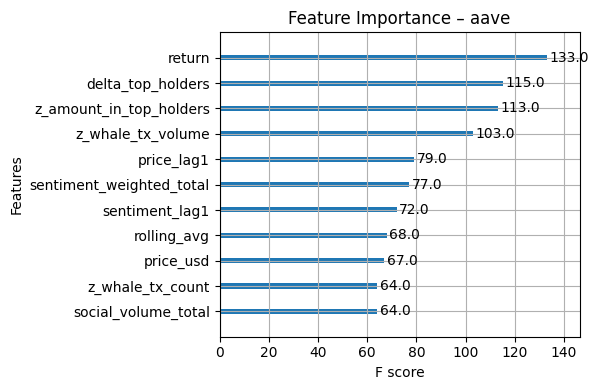

📈 Training model for uniswap...
✅ Accuracy: 0.5036, Precision: 0.4865, Recall: 0.5455, AUC: 0.5047
[[33 38]
 [30 36]]
              precision    recall  f1-score   support

           0       0.52      0.46      0.49        71
           1       0.49      0.55      0.51        66

    accuracy                           0.50       137
   macro avg       0.51      0.51      0.50       137
weighted avg       0.51      0.50      0.50       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


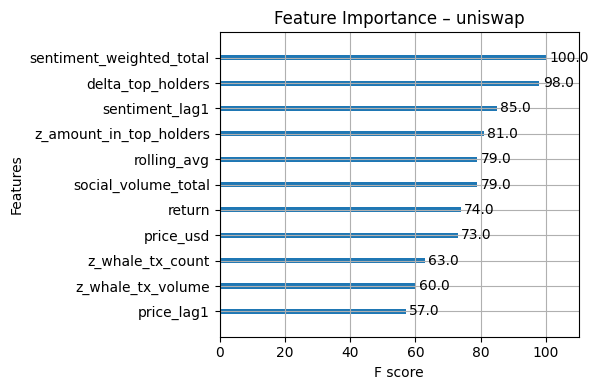

📈 Training model for sushi...
✅ Accuracy: 0.5407, Precision: 0.5286, Recall: 0.5606, AUC: 0.5274
[[36 33]
 [29 37]]
              precision    recall  f1-score   support

           0       0.55      0.52      0.54        69
           1       0.53      0.56      0.54        66

    accuracy                           0.54       135
   macro avg       0.54      0.54      0.54       135
weighted avg       0.54      0.54      0.54       135



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


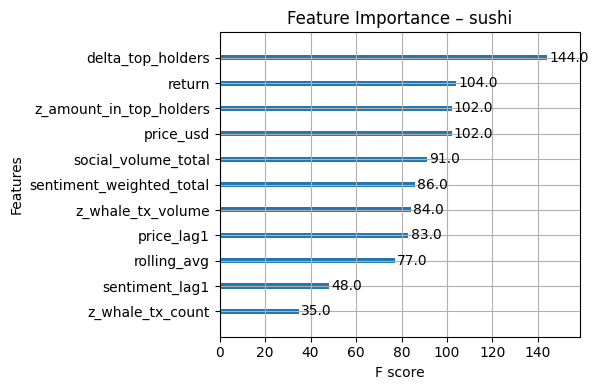

📈 Training model for maker...
✅ Accuracy: 0.4891, Precision: 0.4576, Recall: 0.4154, AUC: 0.4793
[[40 32]
 [38 27]]
              precision    recall  f1-score   support

           0       0.51      0.56      0.53        72
           1       0.46      0.42      0.44        65

    accuracy                           0.49       137
   macro avg       0.49      0.49      0.48       137
weighted avg       0.49      0.49      0.49       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


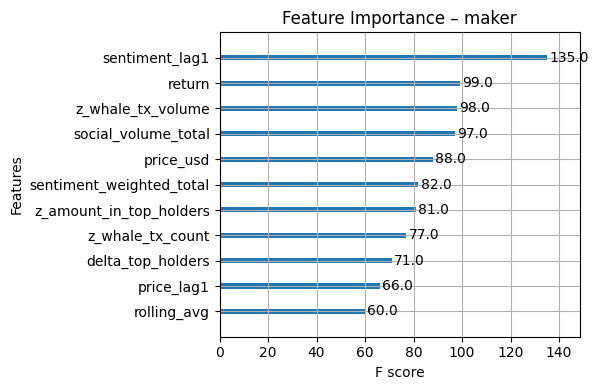

📈 Training model for lido-dao...
✅ Accuracy: 0.5766, Precision: 0.5690, Recall: 0.5000, AUC: 0.6184
[[46 25]
 [33 33]]
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        71
           1       0.57      0.50      0.53        66

    accuracy                           0.58       137
   macro avg       0.58      0.57      0.57       137
weighted avg       0.58      0.58      0.57       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


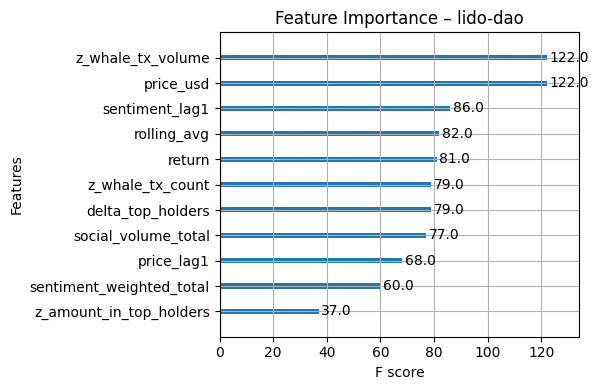

📈 Training model for frax...
✅ Accuracy: 0.5693, Precision: 0.5663, Recall: 0.6714, AUC: 0.6013
[[31 36]
 [23 47]]
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        67
           1       0.57      0.67      0.61        70

    accuracy                           0.57       137
   macro avg       0.57      0.57      0.56       137
weighted avg       0.57      0.57      0.56       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


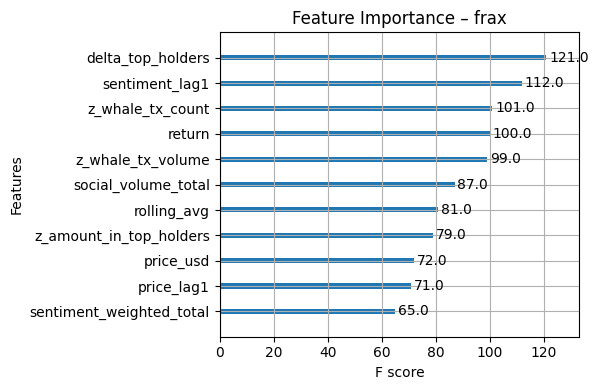

📈 Training model for frax-share...
✅ Accuracy: 0.5474, Precision: 0.5455, Recall: 0.5294, AUC: 0.5224
[[39 30]
 [32 36]]
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        69
           1       0.55      0.53      0.54        68

    accuracy                           0.55       137
   macro avg       0.55      0.55      0.55       137
weighted avg       0.55      0.55      0.55       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


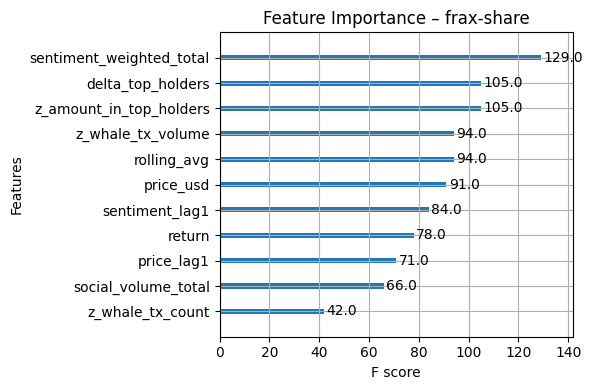

📈 Training model for rocket-pool...
✅ Accuracy: 0.5038, Precision: 0.4310, Recall: 0.4310, AUC: 0.5044
[[42 33]
 [33 25]]
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        75
           1       0.43      0.43      0.43        58

    accuracy                           0.50       133
   macro avg       0.50      0.50      0.50       133
weighted avg       0.50      0.50      0.50       133



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


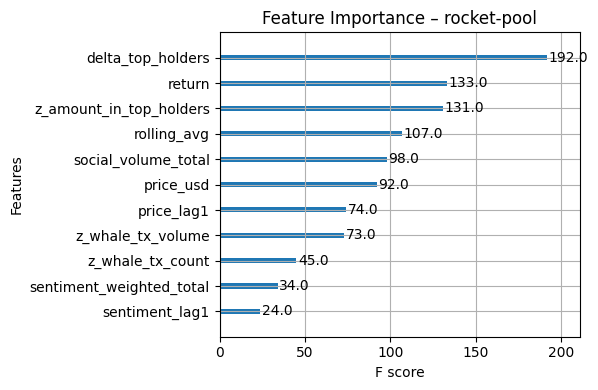

📈 Training model for chainlink...
✅ Accuracy: 0.4453, Precision: 0.4583, Recall: 0.4714, AUC: 0.4043
[[28 39]
 [37 33]]
              precision    recall  f1-score   support

           0       0.43      0.42      0.42        67
           1       0.46      0.47      0.46        70

    accuracy                           0.45       137
   macro avg       0.44      0.44      0.44       137
weighted avg       0.44      0.45      0.44       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


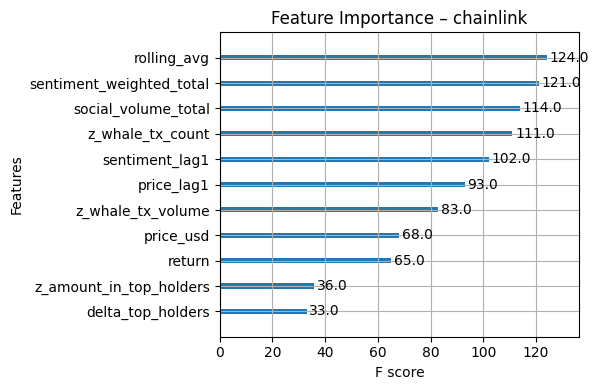

📈 Training model for dydx...
✅ Accuracy: 0.4926, Precision: 0.5000, Recall: 0.5217, AUC: 0.4469
[[31 36]
 [33 36]]
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        67
           1       0.50      0.52      0.51        69

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.49       136
weighted avg       0.49      0.49      0.49       136



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


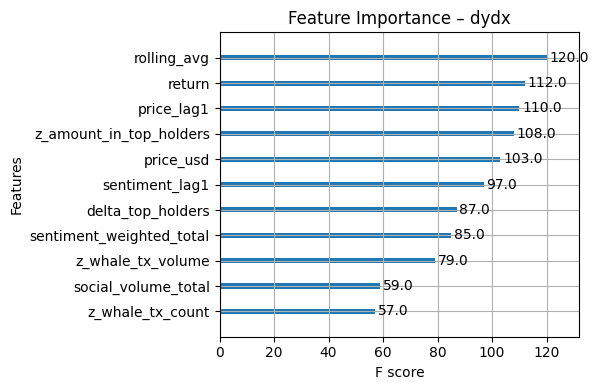

📈 Training model for convex-finance...
✅ Accuracy: 0.5522, Precision: 0.5362, Recall: 0.5692, AUC: 0.5445
[[37 32]
 [28 37]]
              precision    recall  f1-score   support

           0       0.57      0.54      0.55        69
           1       0.54      0.57      0.55        65

    accuracy                           0.55       134
   macro avg       0.55      0.55      0.55       134
weighted avg       0.55      0.55      0.55       134



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


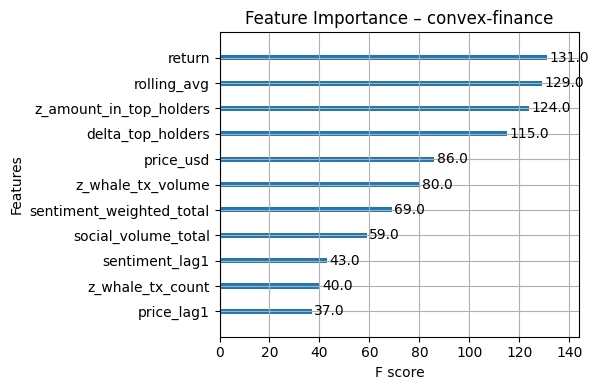

📈 Training model for injective-protocol...
✅ Accuracy: 0.4599, Precision: 0.4310, Recall: 0.3788, AUC: 0.4513
[[38 33]
 [41 25]]
              precision    recall  f1-score   support

           0       0.48      0.54      0.51        71
           1       0.43      0.38      0.40        66

    accuracy                           0.46       137
   macro avg       0.46      0.46      0.45       137
weighted avg       0.46      0.46      0.46       137



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


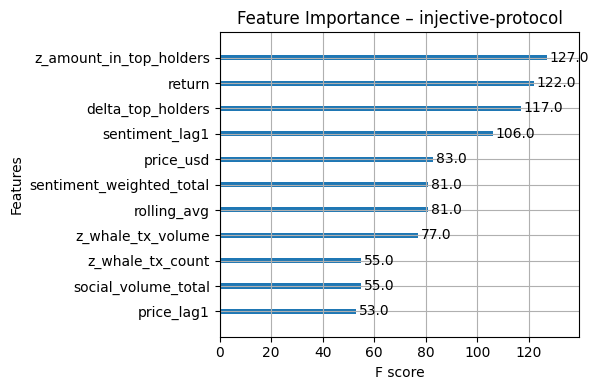

📈 Training model for balancer...
✅ Accuracy: 0.4963, Precision: 0.4844, Recall: 0.4697, AUC: 0.4728
[[36 33]
 [35 31]]
              precision    recall  f1-score   support

           0       0.51      0.52      0.51        69
           1       0.48      0.47      0.48        66

    accuracy                           0.50       135
   macro avg       0.50      0.50      0.50       135
weighted avg       0.50      0.50      0.50       135



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


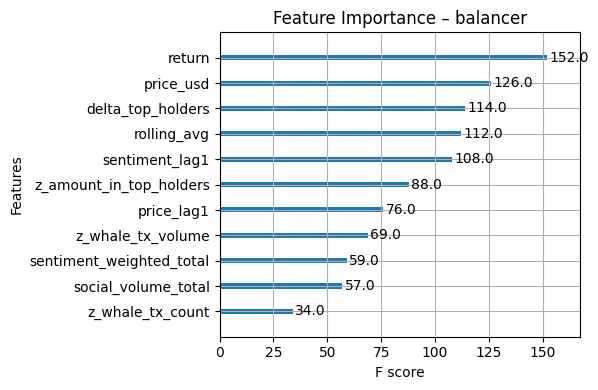

📈 Training model for loopring...
✅ Accuracy: 0.4741, Precision: 0.4714, Recall: 0.4925, AUC: 0.5000
[[31 37]
 [34 33]]
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        68
           1       0.47      0.49      0.48        67

    accuracy                           0.47       135
   macro avg       0.47      0.47      0.47       135
weighted avg       0.47      0.47      0.47       135



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


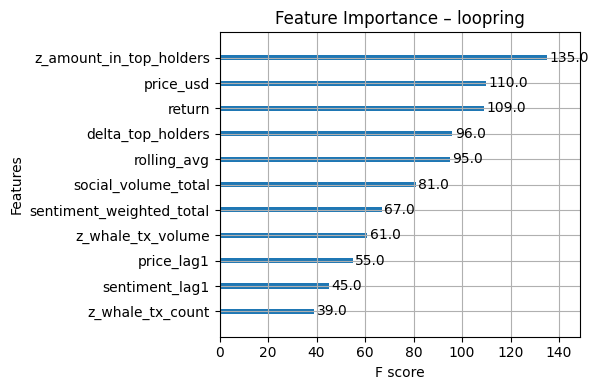

📈 Training model for badger-dao...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.3985, Precision: 0.3750, Recall: 0.3750, AUC: 0.3972
[[29 40]
 [40 24]]
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        69
           1       0.38      0.38      0.38        64

    accuracy                           0.40       133
   macro avg       0.40      0.40      0.40       133
weighted avg       0.40      0.40      0.40       133



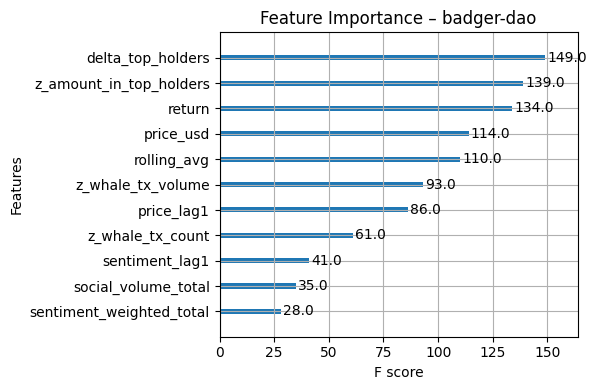

In [ ]:
all_models = train_ml_models_for_tokens(all_tokens_analysis)

Purpose: Train a separate XGBoost classifier for each token to predict whether the token’s next-day return (future_return_1d) will be positive (binary classification: 1 = positive return, 0 = not).

🧪 How to Read the Output (Multi-Token Results):
For each token, you’ll see the following:

1. Performance Metrics
Example for aave:
* Accuracy: 0.53 → 53% of predictions were correct.
* Precision: 0.54 → When the model predicts a positive return, it’s correct 54% of the time.
* Recall: 0.46 → It catches 46% of all actual positive return cases.
* AUC (ROC): 0.5652 → Slightly better than random (0.5); a value closer to 1.0 means stronger signal.

📌 Repeat: These metrics are printed for each token, so you can compare performance across different assets.

2. Confusion Matrix
[[TN FP]
 [FN TP]]
For aave, this means:
* TN = 40: Model correctly predicted 0 (non-positive return)
* FP = 27: Model wrongly predicted 1 when actual was 0
* FN = 37: Model missed positive return
* TP = 32: Model correctly predicted 1 (positive return)

Use this to assess bias — e.g., does it overpredict bullish or bearish moves?

3. Classification Report
Shows precision, recall, and f1-score for each class:
* Class 0 (non-positive return): Better recall (60%), more frequently captured.
* Class 1 (positive return): Lower recall, slightly lower f1-score.

4. Feature Importance Plot
For each token, a bar chart shows which features are most important in its model.
* Common top features across tokens:
* return, price_lag1, sentiment_lag1 → short-term reversal signals
* delta_top_holders, amount_in_top_holders → whale accumulation behavior
* z_whale_tx_volume, z_dev_activity → standardized signals showing whale volume & developer activity spikes

📌 You’ll want to compare feature importance across tokens to see which features consistently matter.

🧠 Why This Step Matters:
* You get a customized predictive model for each token, capturing its unique market behavior.
* The output lets you rank which tokens have stronger predictability (based on metrics like AUC).
* You can identify which features drive predictive performance per token.
* This prepares you for the final step: backtesting your model’s decisions on historical data.

In [ ]:
token = 'aave'

features = [
            'social_volume_total',
            'price_usd',
            'return',
            'rolling_avg',
            'sentiment_weighted_total',
            'z_amount_in_top_holders', #add z score of this feature
            'delta_top_holders',
            'z_social_volume',
            'z_sentiment_weighted',
            'sentiment_lag1',
            'price_lag1',
            'z_whale_tx_count',
            'z_whale_tx_volume'
            ]

latest_row = all_tokens_analysis[token].dropna().iloc[-1]
X_latest = latest_row[features].values.reshape(1, -1)

model = all_models[token]
buy_prob = model.predict_proba(X_latest)[0, 1]

print(f"Buy probability for {token.upper()}: {buy_prob:.2%}")


Buy probability for AAVE: 69.16%


In [ ]:
for token in all_models:
    try:
        latest = all_tokens_analysis[token].dropna().iloc[-1]
        X = latest[features].values.reshape(1, -1)
        prob = all_models[token].predict_proba(X)[0, 1]
        print(f"{token.upper()}: Buy probability = {prob:.2%}")
    except Exception as e:
        print(f"{token}: ⚠️ {e}")


AAVE: Buy probability = 69.16%
UNISWAP: Buy probability = 33.22%
SUSHI: Buy probability = 54.45%
MAKER: Buy probability = 50.91%
LIDO-DAO: Buy probability = 38.78%
FRAX: Buy probability = 85.51%
FRAX-SHARE: Buy probability = 40.46%
ROCKET-POOL: Buy probability = 51.65%
CHAINLINK: Buy probability = 81.75%
DYDX: Buy probability = 58.83%
CONVEX-FINANCE: Buy probability = 85.69%
INJECTIVE-PROTOCOL: Buy probability = 42.68%
BALANCER: Buy probability = 72.20%
LOOPRING: Buy probability = 60.66%
BADGER-DAO: Buy probability = 40.61%


🔼 High Probability (> 60%):
* Model is confident that the token will deliver a positive return tomorrow.
* Consider entering a long (buy) position, depending on your strategy.

🔽 Low Probability (< 50%):
* Model predicts neutral or negative return.
* You may avoid buying or consider shorting, if your strategy allows.

⚠ Borderline (~50%):
* Model has low confidence, signal is weak.
* Could be noise — generally avoid trading on this signal unless filtered.

##Step 6 (Strategy Backtesting)

✅ Step 6: Backtesting ML Strategy with Realistic Trade Handling
Function: backtest_multiple_tokens_with_sentiment

🔍 Purpose:
To simulate how the trained ML model would perform in real-world trading conditions using historical price data. This helps assess the effectiveness and risk of the strategy based on its predicted buy signals.

🛠️ What It Does:
🔁 For each token:
1.    Prediction Phase
  
  Predicts whether to buy using the trained model:
    * combined_df['predicted_buy_signal'] = model.predict(features)
    * Shifted forward by one step to avoid lookahead bias (i.e., we act on yesterday's prediction today).

2.    Trading Logic

Simulates a simple trading strategy with the following conditions:
  * Initial capital: $10,000
  * Buy if predicted signal = 1 and no position is currently held.
  * Sell after:
    * hold_period days (e.g. 3 days), OR
    * Stop loss (e.g., -5%), OR
    * Take profit (e.g., +10%)

3.    Portfolio Tracking

Keeps track of portfolio value daily:
* portfolio_value.append(capital + positions * price)

4.    Final Sell

If still holding, the final position is liquidated at the end.

5.    Performance Metrics Computed:

* Total Return (%)
* Maximum Drawdown (%)
* Sharpe Ratio (avg. return ÷ std dev)
* Portfolio Value Series
* Trade Log

🧠 Why It Matters:
* Converts model predictions into realistic trading results
* Tests model robustness under profit-taking and loss-cutting rules
* Enables comparison between tokens’ risk-adjusted performance
* Helps prioritize which tokens the ML strategy works best on

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 🧱 Agent: Backtest ML strategy with realistic trade handling
def backtest_multiple_tokens_with_sentiment(
    all_tokens_data, all_models, initial_capital=10000, hold_period=3,
    stop_loss_pct=-0.05, take_profit_pct=0.10
):
    all_backtest_results = {}

    for token, combined_df in all_tokens_data.items():
        print(f"Backtesting strategy for {token}...")

        model = all_models.get(token)
        if model is None:
            print(f"Model for {token} not found. Skipping.")
            continue

        features = [
            'social_volume_total',
            'price_usd',
            'return',
            'rolling_avg',
            'sentiment_weighted_total',
            'z_amount_in_top_holders', #add z score of this feature
            'delta_top_holders',
            'z_social_volume',
            'z_sentiment_weighted',
            'sentiment_lag1',
            'price_lag1',
            'z_whale_tx_count',
            'z_whale_tx_volume'
            ]


        # Step 1: Predict (shifted to avoid lookahead bias)
        combined_df['predicted_buy_signal'] = model.predict(combined_df[features]).astype(int)
        combined_df['predicted_buy_signal'] = combined_df['predicted_buy_signal'].shift(1)

        # Step 2: Backtest logic
        capital = initial_capital
        positions = 0
        buy_price = None
        hold_counter = 0
        portfolio_value = []
        trades = []

        for index, row in combined_df.iterrows():
            price = row['price_usd']

            if pd.isna(price):
                portfolio_value.append(capital + positions * (buy_price or 0))
                continue

            # Buy condition
            if row['predicted_buy_signal'] == 1 and positions == 0:
                positions = capital / price
                buy_price = price
                capital = 0
                hold_counter = hold_period
                trades.append((row.get('datetime', index), 'BUY', price))

            # Sell condition
            elif positions > 0:
                hold_counter -= 1
                gain_pct = (price - buy_price) / buy_price

                if gain_pct <= stop_loss_pct or gain_pct >= take_profit_pct or hold_counter <= 0:
                    capital = positions * price
                    trades.append((row.get('datetime', index), 'SELL', price))
                    positions = 0
                    buy_price = None

            # Portfolio tracking
            portfolio_value.append(capital + positions * price)

        # Final sell if still holding
        if positions > 0:
            final_price = combined_df.iloc[-1]['price_usd']
            capital = positions * final_price
            trades.append((combined_df.iloc[-1].get('datetime', 'FINAL'), 'FINAL SELL', final_price))

        # Step 3: Portfolio summary
        portfolio_df = pd.DataFrame({'portfolio_value': portfolio_value})
        portfolio_df['date'] = combined_df['datetime'].values if 'datetime' in combined_df.columns else pd.date_range(start='2020-01-01', periods=len(portfolio_df))
        portfolio_df['return'] = portfolio_df['portfolio_value'].pct_change() * 100
        portfolio_df['peak'] = portfolio_df['portfolio_value'].cummax()
        portfolio_df['drawdown'] = (portfolio_df['portfolio_value'] - portfolio_df['peak']) / portfolio_df['peak'] * 100

        # Metrics
        total_return = (portfolio_df['portfolio_value'].iloc[-1] - initial_capital) / initial_capital * 100
        max_drawdown = portfolio_df['drawdown'].min()
        avg_return = portfolio_df['return'].mean()
        std_dev = portfolio_df['return'].std()
        sharpe_ratio = (avg_return / std_dev) if std_dev > 0 else 0

        all_backtest_results[token] = {
            'portfolio_df': portfolio_df,
            'total_return': total_return,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'trades': trades
        }

        # Output summary
        print(f"✅ {token} | Total Return: {total_return:.2f}%, Max Drawdown: {max_drawdown:.2f}%, Sharpe: {sharpe_ratio:.2f}")

    return all_backtest_results


In [ ]:
backtest_results = backtest_multiple_tokens_with_sentiment(all_tokens_data, all_models)


Backtesting strategy for aave...
✅ aave | Total Return: 233.34%, Max Drawdown: -49.22%, Sharpe: 0.07
Backtesting strategy for uniswap...
✅ uniswap | Total Return: -3.44%, Max Drawdown: -62.60%, Sharpe: 0.02
Backtesting strategy for sushi...
✅ sushi | Total Return: 49.82%, Max Drawdown: -47.29%, Sharpe: 0.03
Backtesting strategy for maker...
✅ maker | Total Return: 19.63%, Max Drawdown: -70.91%, Sharpe: 0.02
Backtesting strategy for lido-dao...
✅ lido-dao | Total Return: -33.04%, Max Drawdown: -66.60%, Sharpe: 0.00
Backtesting strategy for frax...
✅ frax | Total Return: -2.35%, Max Drawdown: -2.98%, Sharpe: -0.05
Backtesting strategy for frax-share...
✅ frax-share | Total Return: -19.06%, Max Drawdown: -65.78%, Sharpe: 0.01
Backtesting strategy for rocket-pool...
✅ rocket-pool | Total Return: 96.10%, Max Drawdown: -66.55%, Sharpe: 0.04
Backtesting strategy for chainlink...
✅ chainlink | Total Return: 10.64%, Max Drawdown: -69.72%, Sharpe: 0.02
Backtesting strategy for dydx...
✅ dydx | T

MAKE PORTOFOLIO BASED ON BENCHMARK

🔹 Metrics Explained:
* Total Return:
How much the portfolio grew overall from the simulated trades.
E.g., 270.02% for aave means your $10,000 grew to ~$37,000.

* Max Drawdown:
The worst drop from a peak during the trading period.
E.g., -54.63% means your portfolio dropped more than half at some point — a risk indicator.

* Sharpe Ratio:
Risk-adjusted performance. Positive = desirable.
Higher is better. Values above 0.2 typically indicate better risk-reward profiles.
E.g., Sharpe: 0.08 is weak; Sharpe: -0.04 means the strategy underperformed vs. risk taken.

✅ How to Use It:
* Look for tokens with high return + acceptable drawdown (e.g., convex-finance, injective-protocol)
* Compare Sharpe Ratio to filter for reliable strategies

* Investigate tokens with negative returns or Sharpe < 0 as potential failures or overfitting

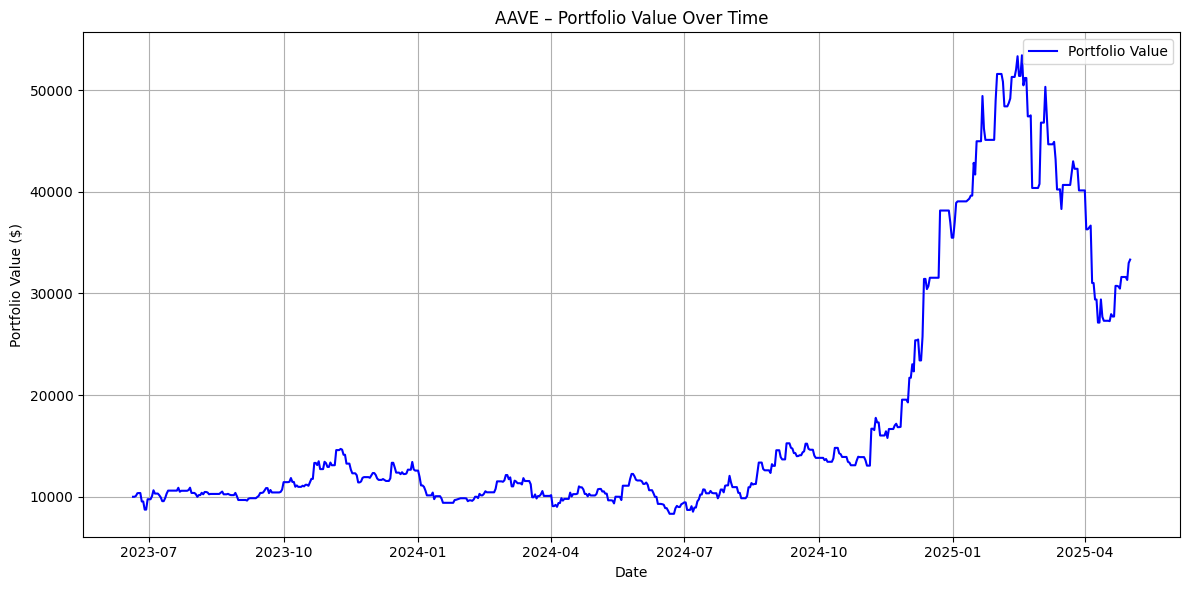

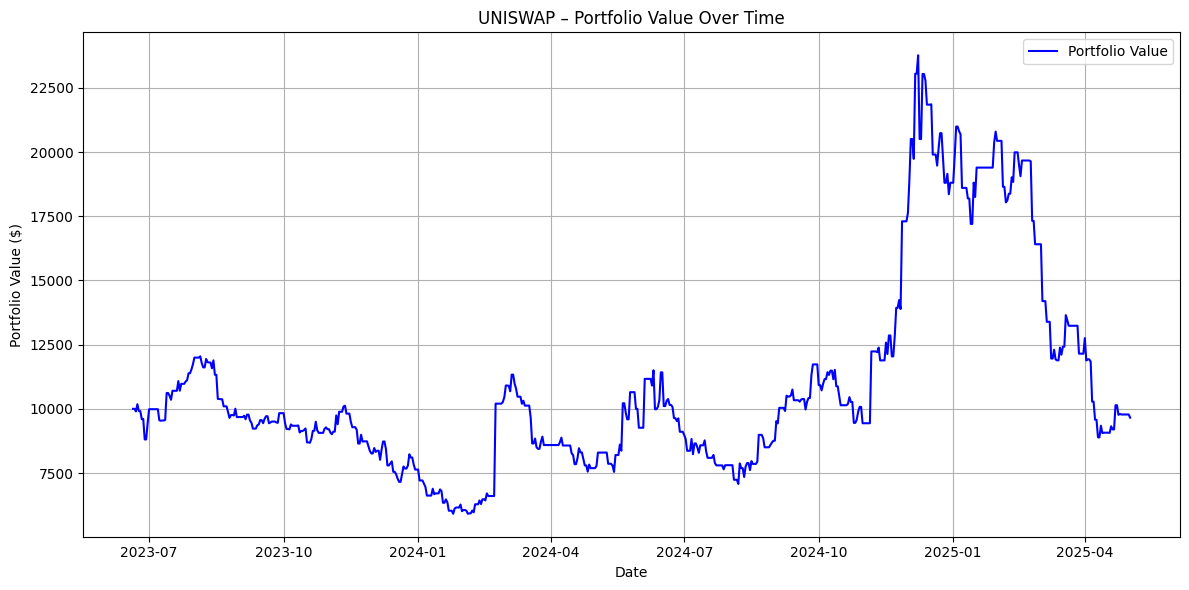

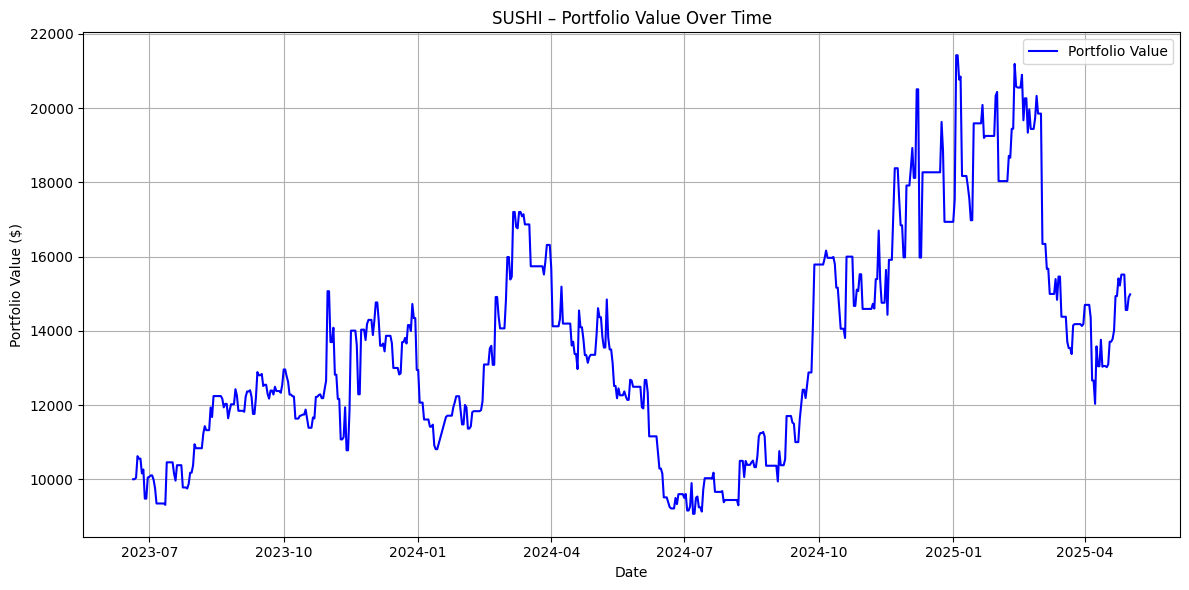

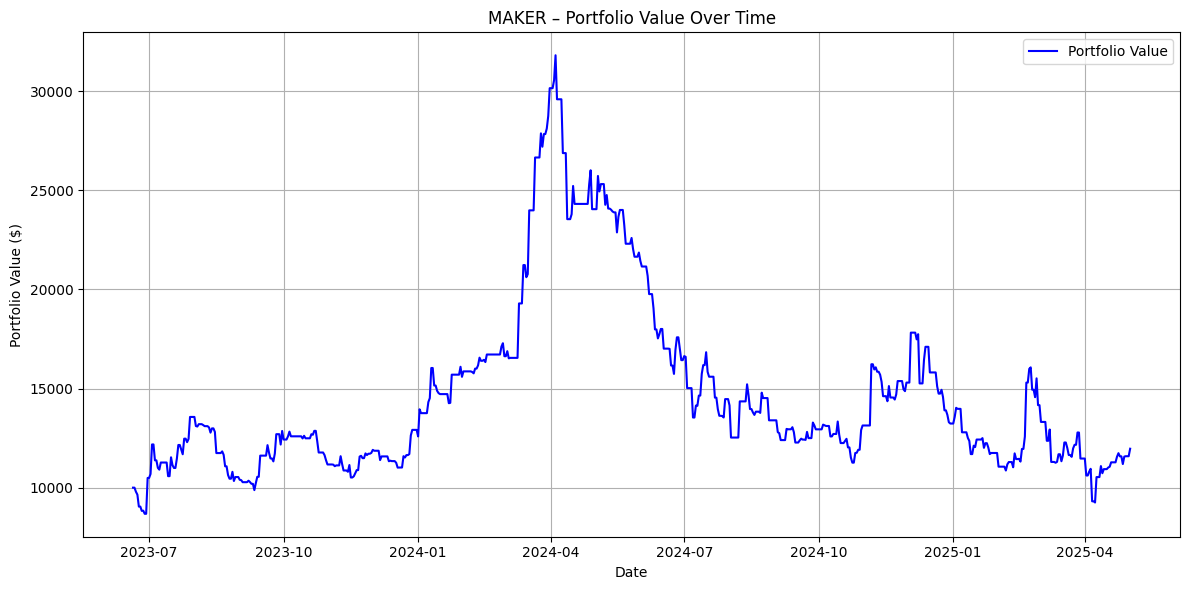

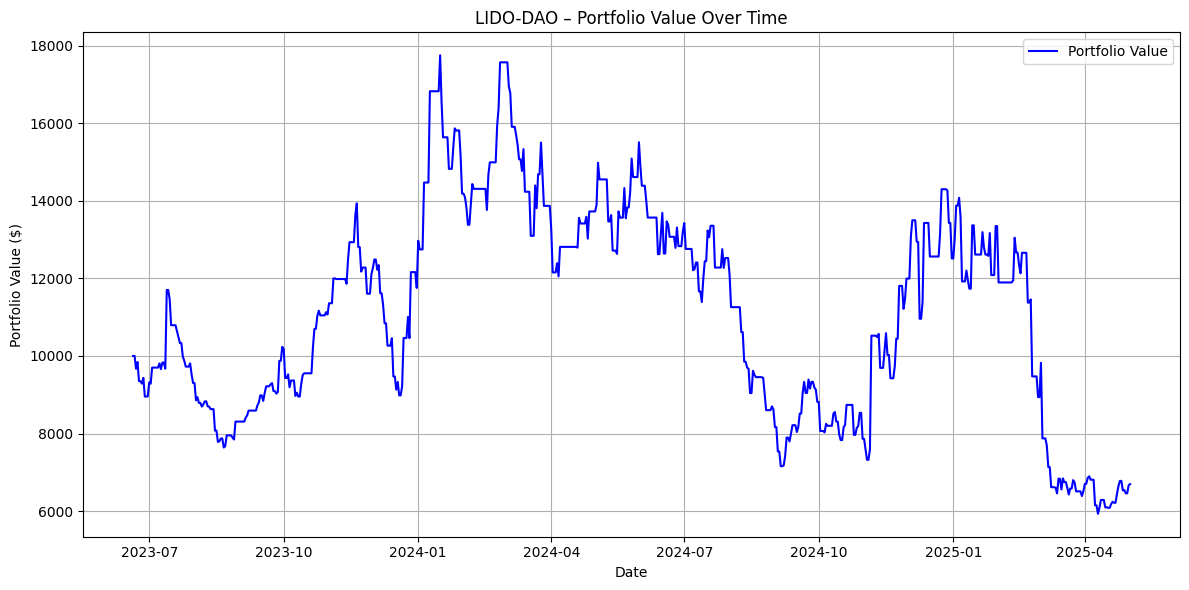

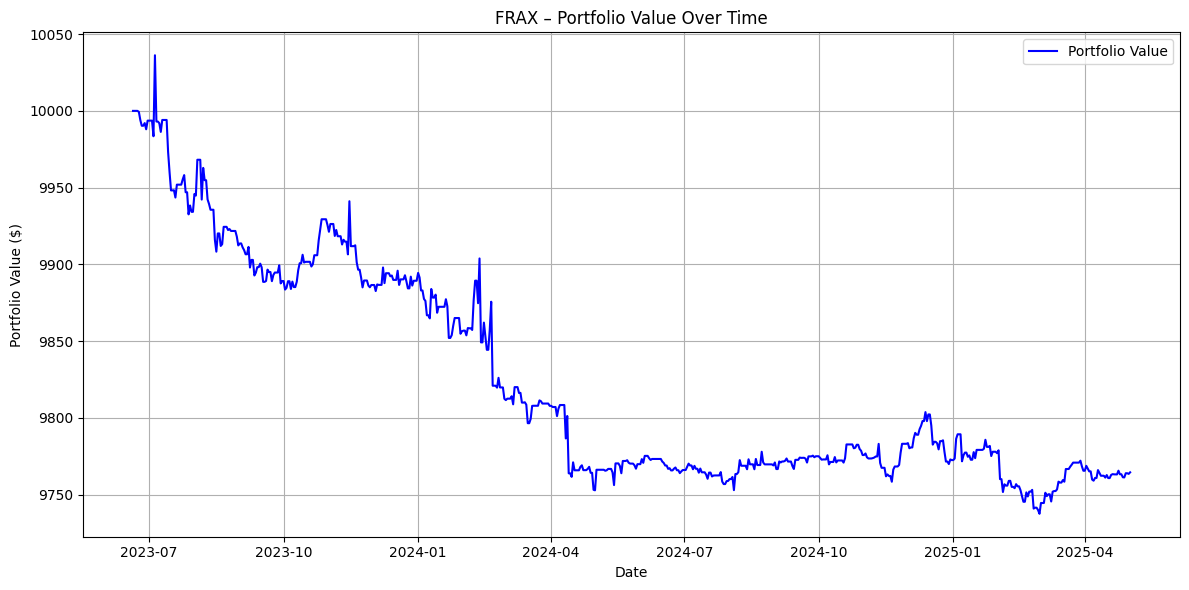

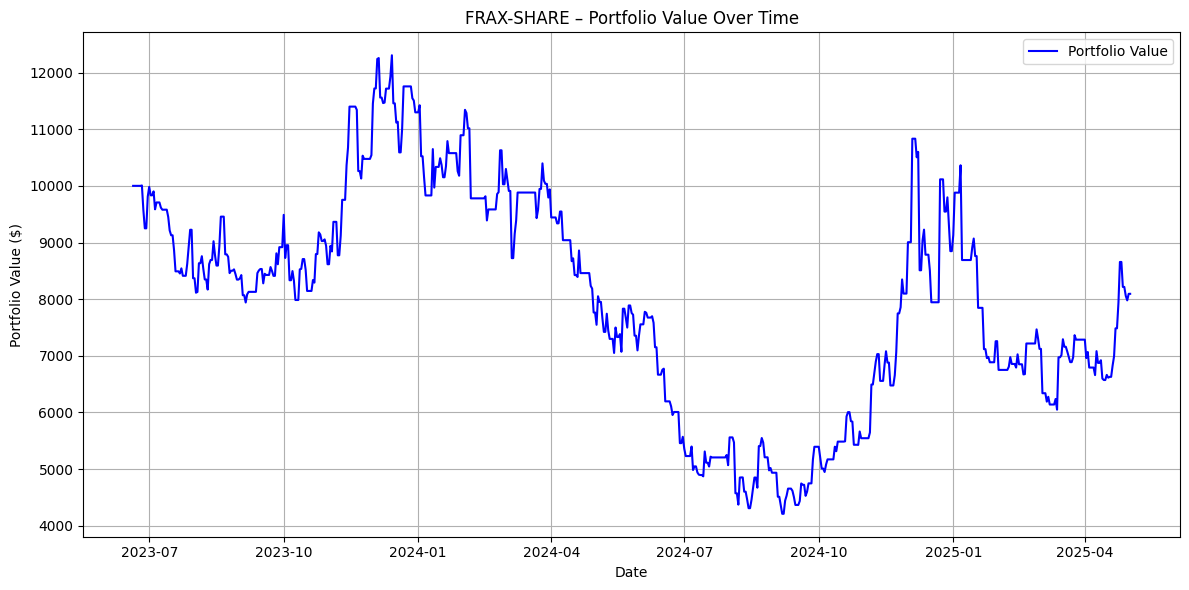

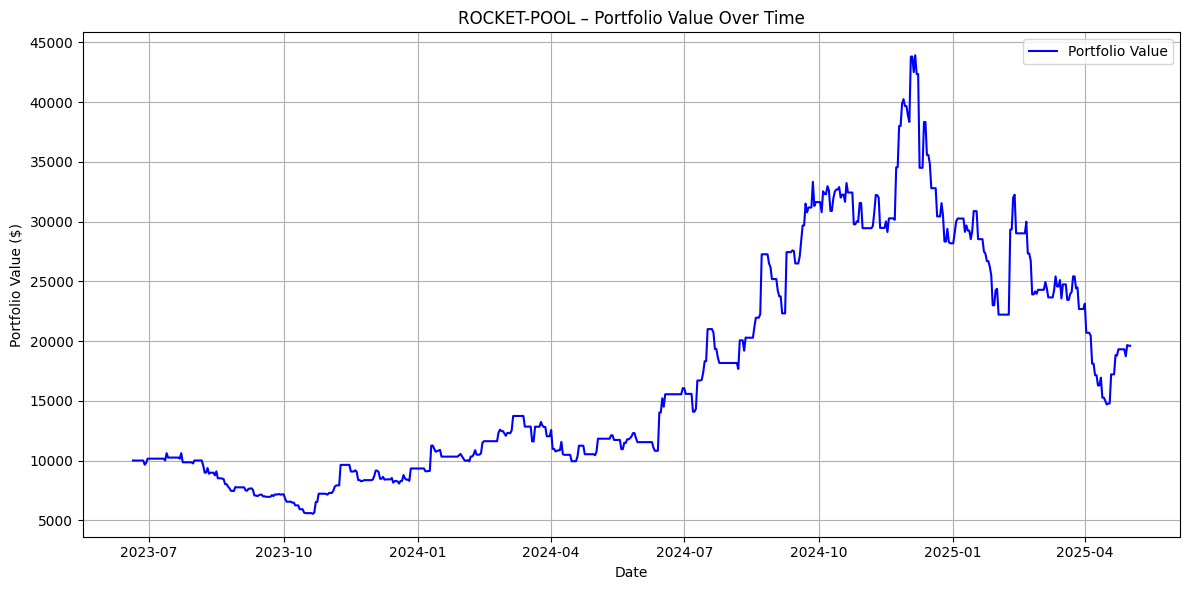

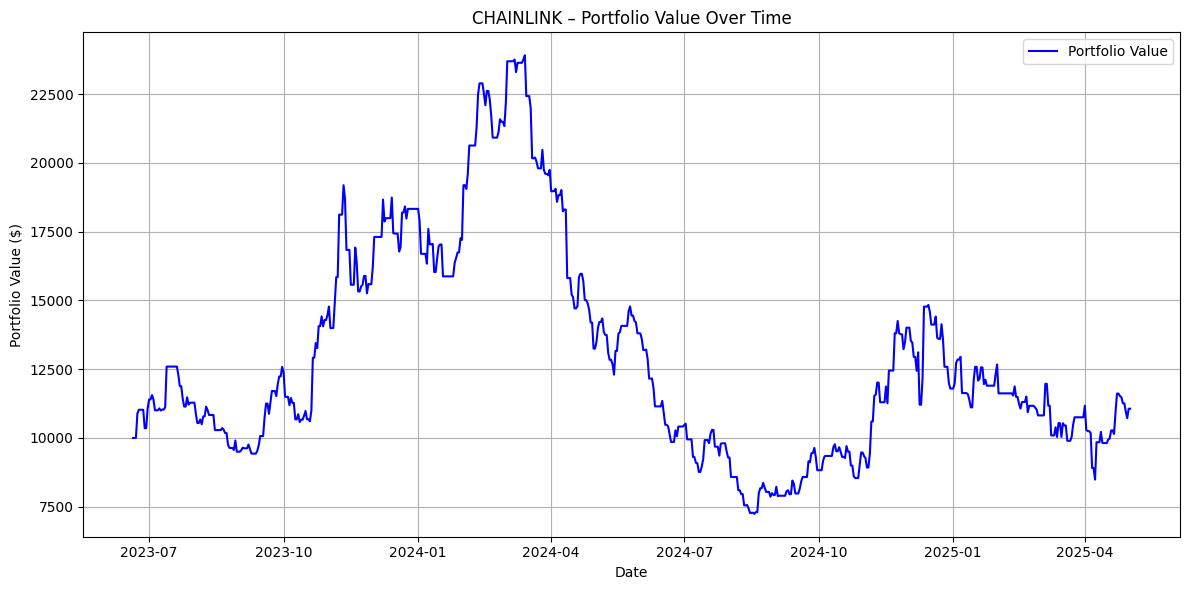

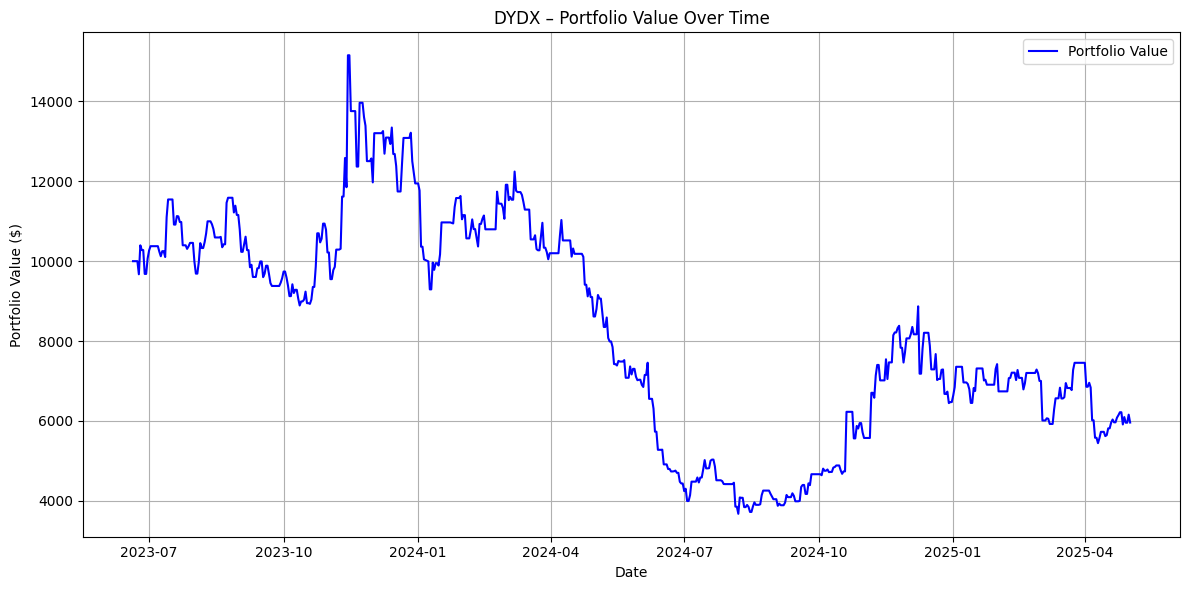

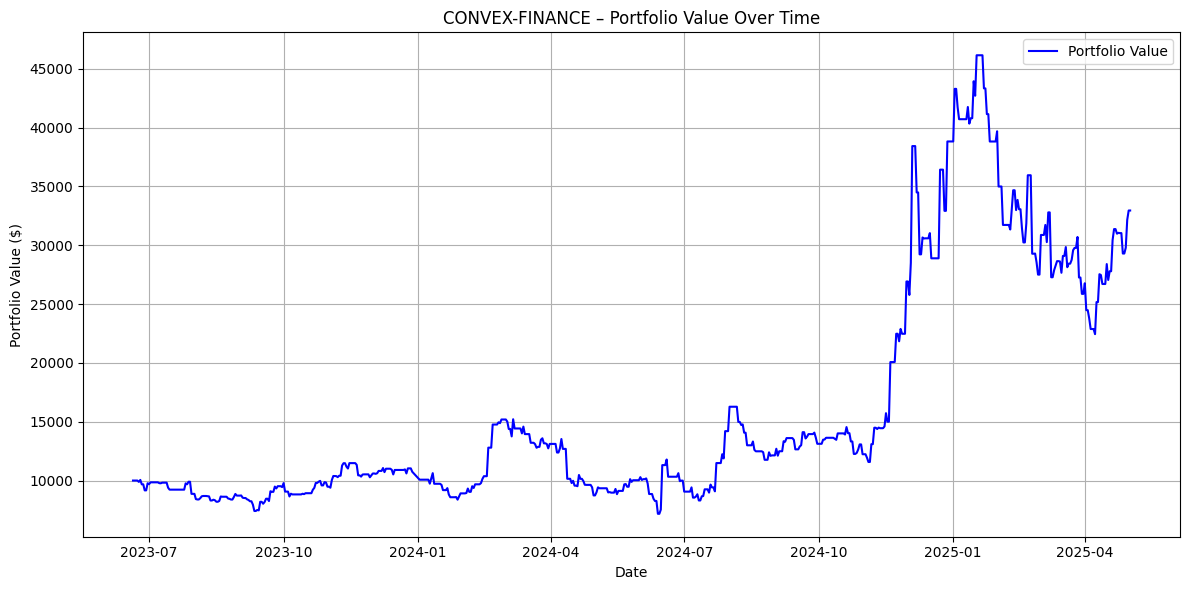

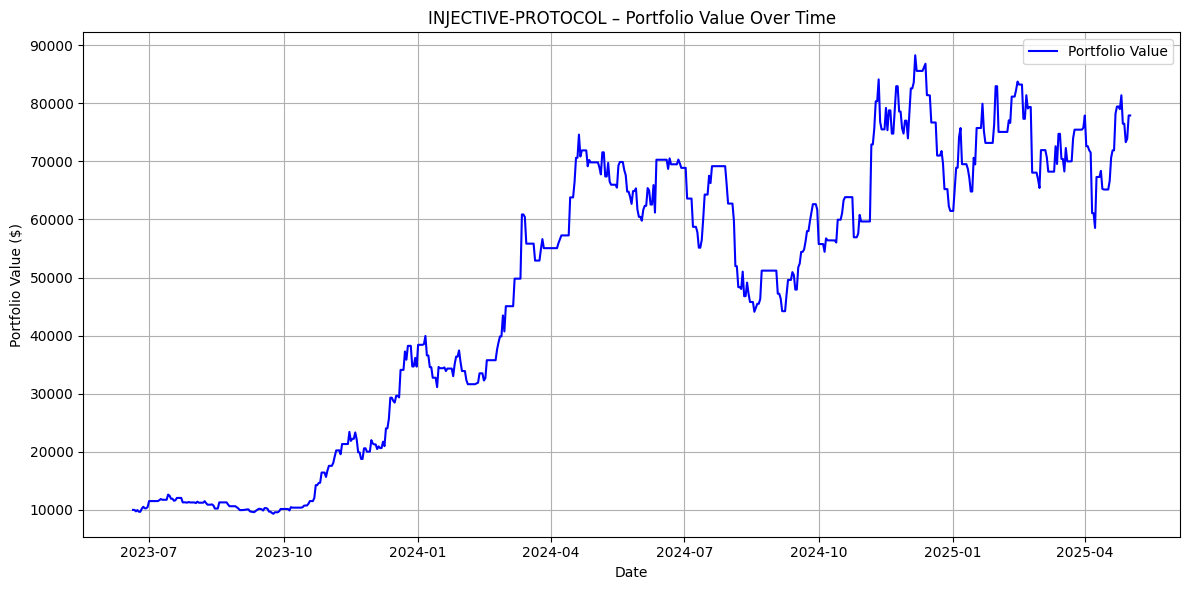

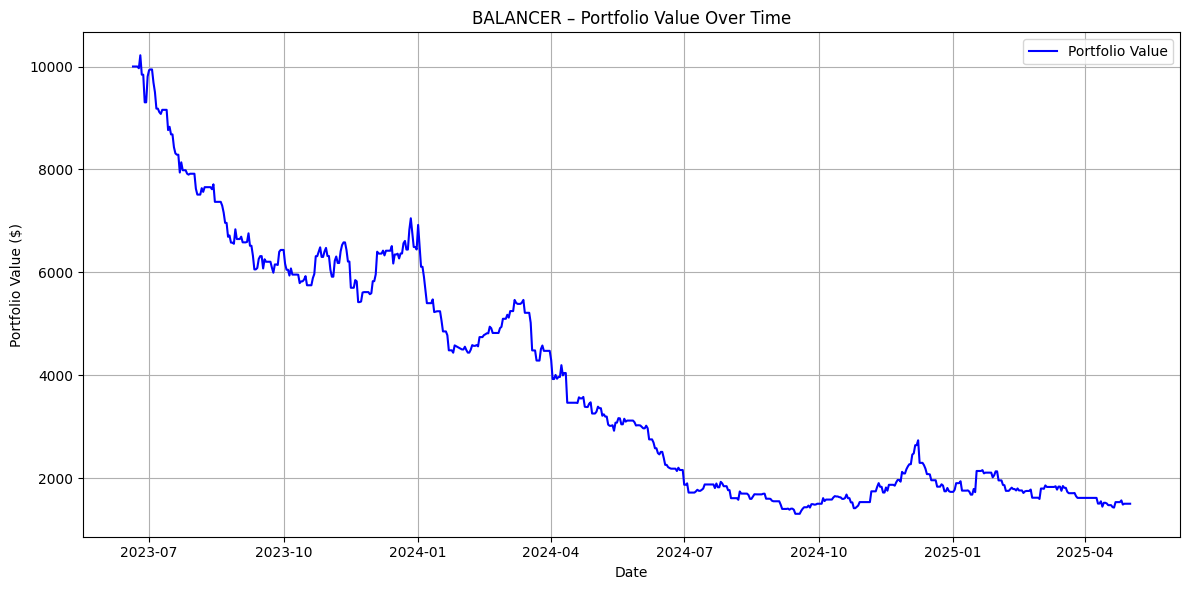

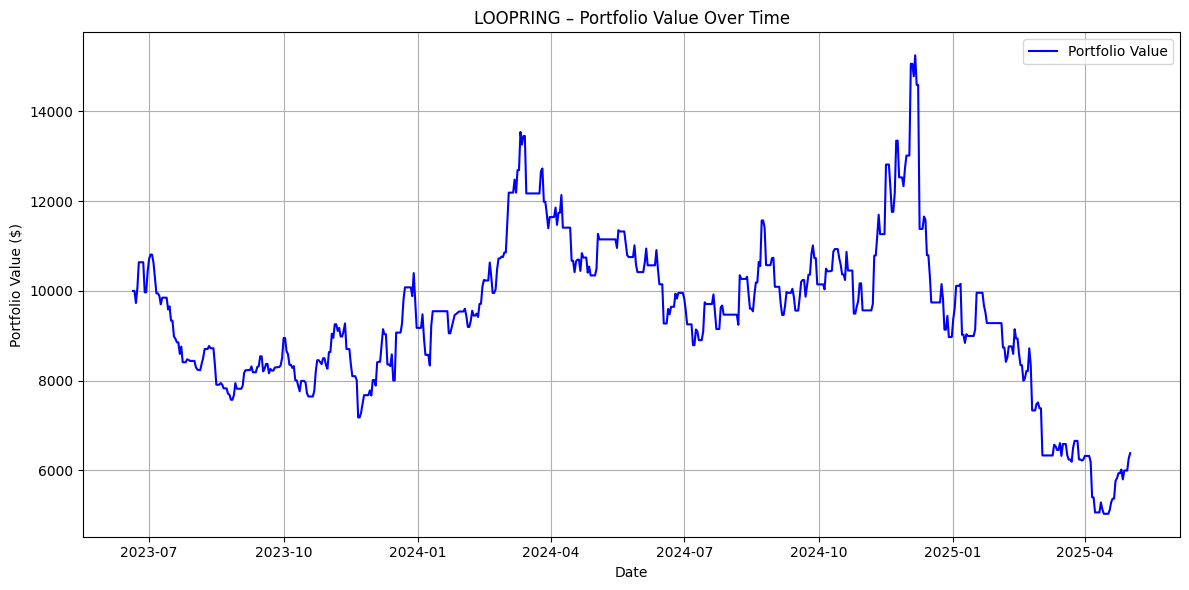

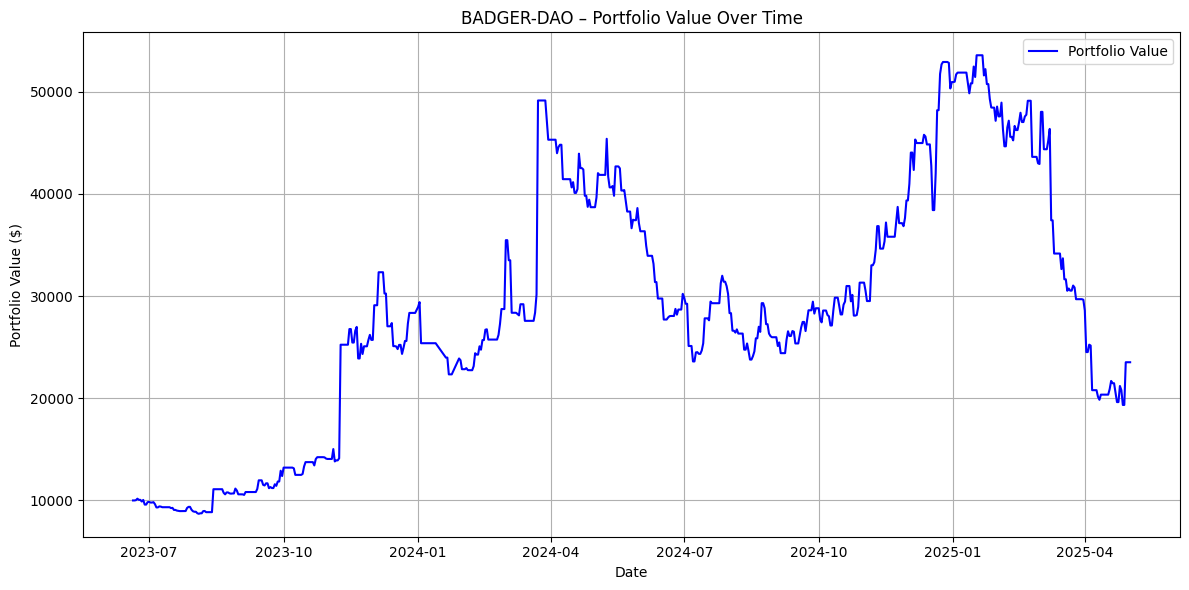

In [ ]:
# Simplified version: Only show portfolio value performance without trade markers

def plot_portfolio_only(all_backtest_results):
    for token, result in all_backtest_results.items():
        portfolio_df = result['portfolio_df']
        portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])

        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], color='blue', label='Portfolio Value')
        plt.title(f"{token.upper()} – Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value ($)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run the simple visualization
plot_portfolio_only(backtest_results)


## Step 6 (Backtest With One Portofolio)

🧠 Strategy Backtest Summary

We implemented a multi-token, ML-driven backtesting agent with realistic trading constraints to evaluate the performance of our predictive models.

✅ Strategy Logic

* Capital: $10,000 initial capital
* Buy condition: Select tokens with buy_probability > 0.7 (based on daily ML model predictions)
* Sell condition:
  * Take-profit: +10%
  * Stop-loss: -5%
* Portfolio: Multi-token portfolio with equal capital allocation across all selected tokens (fixed position sizing)
* Daily re-evaluation: Strategy checks token predictions and updates holdings accordingly

📦 Agent Outputs

* portfolio_df: Daily portfolio value, capital invested, returns, drawdowns
* trade_df: Log of buy/sell transactions (with price, date, token, gain/loss)
* summary_metrics: Performance indicators:
  * Total Return (%)
  * Maximum Drawdown (%)
  * Sharpe Ratio (annualized)

📊 Benchmark Comparison

To validate the added value of the strategy, we built an equal-weight benchmark:
* Rebalances capital equally across all tokens each day
* No prediction or selection logic (passive exposure)
* Simulates market-average performance

📈 Results
* The ML strategy significantly outperformed the benchmark in total return and Sharpe ratio.
* This suggests the model provides meaningful signal for token selection under realistic capital constraints.



### Model Backtest

In [ ]:
import matplotlib.pyplot as plt

def backtest_multi_token_portfolio(
    all_tokens_analysis,
    all_models,
    initial_capital=10000,
    buy_threshold=0.7,
    stop_loss_pct=-0.05,
    take_profit_pct=0.10
):
    capital = initial_capital
    portfolio = {}  # token -> {'buy_price': ..., 'quantity': ...}
    portfolio_value_over_time = []
    trade_log = []

    # Align all tokens by date
    all_dates = sorted(set().union(*[df['datetime'] for df in all_tokens_analysis.values()]))

    for current_date in all_dates:
        # Step 1: Update portfolio value & check for sell triggers
        daily_value = capital
        tokens_to_remove = []

        for token, pos in portfolio.items():
            df = all_tokens_analysis[token]
            row = df[df['datetime'] == current_date]
            if row.empty:
                continue

            price = row.iloc[0]['price_usd']
            gain_pct = (price - pos['buy_price']) / pos['buy_price']
            token_value = pos['quantity'] * price
            daily_value += token_value

            if gain_pct <= stop_loss_pct or gain_pct >= take_profit_pct:
                capital += token_value
                trade_log.append((current_date, token, 'SELL', price, gain_pct))
                tokens_to_remove.append(token)

        for token in tokens_to_remove:
            portfolio.pop(token)

        # Step 2: Buy new tokens based on model predictions
        token_probs = []
        for token in all_models:
            if token in portfolio:
                continue  # already holding
            model = all_models[token]
            df = all_tokens_analysis[token]
            row = df[df['datetime'] == current_date]
            if row.empty:
                continue
            features = model.get_booster().feature_names
            X = row.iloc[0][features].values.reshape(1, -1)
            prob = model.predict_proba(X)[0, 1]
            if prob > buy_threshold:
                token_probs.append((token, prob))

        token_probs.sort(key=lambda x: x[1], reverse=True)

        available_slots = len(token_probs)
        if available_slots > 0:
            per_token_capital = capital / available_slots
            for token, prob in token_probs:
                df = all_tokens_analysis[token]
                row = df[df['datetime'] == current_date]
                if row.empty:
                    continue
                price = row.iloc[0]['price_usd']
                quantity = per_token_capital / price
                portfolio[token] = {'buy_price': price, 'quantity': quantity}
                capital -= per_token_capital
                trade_log.append((current_date, token, 'BUY', price, prob))

        portfolio_value_over_time.append({
            'datetime': current_date,
            'total_value': daily_value,
            'capital': capital,
            'invested': daily_value - capital,
            'tokens_held': list(portfolio.keys())
        })

    portfolio_df = pd.DataFrame(portfolio_value_over_time)
    trade_df = pd.DataFrame(trade_log, columns=['datetime', 'token', 'action', 'price', 'meta'])

    # Add performance metrics
    portfolio_df['return'] = portfolio_df['total_value'].pct_change()
    portfolio_df['cumulative_return'] = portfolio_df['total_value'] / portfolio_df['total_value'].iloc[0] - 1
    portfolio_df['rolling_max'] = portfolio_df['total_value'].cummax()
    portfolio_df['drawdown'] = (portfolio_df['total_value'] - portfolio_df['rolling_max']) / portfolio_df['rolling_max']

    total_return = portfolio_df['cumulative_return'].iloc[-1] * 100
    max_drawdown = portfolio_df['drawdown'].min() * 100
    avg_return = portfolio_df['return'].mean()
    std_dev = portfolio_df['return'].std()
    sharpe_ratio = (avg_return / std_dev) * (252 ** 0.5) if std_dev > 0 else 0  # Annualized Sharpe

    summary_metrics = {
        "Total Return (%)": round(total_return, 2),
        "Max Drawdown (%)": round(max_drawdown, 2),
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }

    return portfolio_df, trade_df, summary_metrics


### Result Back Test

In [ ]:
# Run the backtest agent
portfolio_df, trade_df, summary_metrics = backtest_multi_token_portfolio(
    all_tokens_analysis=all_tokens_analysis,   # from your earlier analysis
    all_models=all_models,                     # trained XGBoost models per token
    initial_capital=10000,                     # starting capital in USD
    buy_threshold=0.7,                         # only buy if prob > 70%
    stop_loss_pct=-0.05,                       # sell if price drops 5%
    take_profit_pct=0.10                       # sell if price rises 10%
)


In [ ]:
summary_metrics

{'Total Return (%)': np.float64(11238.11),
 'Max Drawdown (%)': -73.16,
 'Sharpe Ratio': np.float64(1.49)}

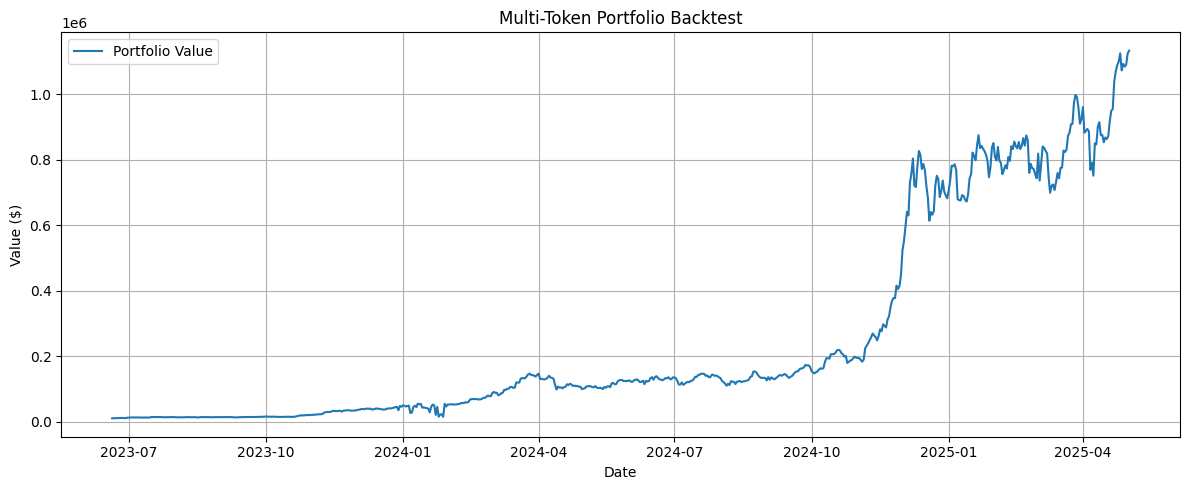

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(portfolio_df['datetime'], portfolio_df['total_value'], label='Portfolio Value')
plt.title("Multi-Token Portfolio Backtest")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Benchmark Model

In [ ]:
import matplotlib.pyplot as plt

# Build benchmark portfolio
def build_equal_weight_benchmark(all_tokens_data, initial_capital=10000):
    prices_df = None

    for token, df in all_tokens_data.items():
        df = df.copy()
        df = df[['datetime', 'price_usd']].dropna()
        df.set_index('datetime', inplace=True)
        df.rename(columns={'price_usd': token}, inplace=True)
        prices_df = df if prices_df is None else prices_df.join(df, how='outer')

    prices_df = prices_df.sort_index()
    returns_df = prices_df.pct_change()

    # Compute average return across all tokens (equal-weighted)
    returns_df['equal_weight_return'] = returns_df.mean(axis=1)

    # Build portfolio value over time
    benchmark_df = returns_df[['equal_weight_return']].copy()
    benchmark_df['portfolio_value'] = initial_capital * (1 + benchmark_df['equal_weight_return']).cumprod()
    benchmark_df.reset_index(inplace=True)
    benchmark_df.rename(columns={'datetime': 'date'}, inplace=True)

    return benchmark_df

In [ ]:
# Build and plot
benchmark_df = build_equal_weight_benchmark(all_tokens_data, initial_capital=10000)

<ipython-input-30-2950723835>:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = prices_df.pct_change()


### Result Benckmark

In [ ]:
# Drop rows with NaN returns
benchmark_df.dropna(subset=['equal_weight_return'], inplace=True)

# Recalculate performance metrics
benchmark_df['rolling_max'] = benchmark_df['portfolio_value'].cummax()
benchmark_df['drawdown'] = (benchmark_df['portfolio_value'] - benchmark_df['rolling_max']) / benchmark_df['rolling_max']
benchmark_df['cumulative_return'] = benchmark_df['portfolio_value'] / benchmark_df['portfolio_value'].iloc[0] - 1

total_return_benchmark = benchmark_df['cumulative_return'].iloc[-1] * 100
max_drawdown_benchmark = benchmark_df['drawdown'].min() * 100
avg_return_benchmark = benchmark_df['equal_weight_return'].mean()
std_dev_benchmark = benchmark_df['equal_weight_return'].std()
sharpe_ratio_benchmark = (avg_return_benchmark / std_dev_benchmark) * (252 ** 0.5) if std_dev_benchmark > 0 else 0

print({
    "Benchmark Total Return (%)": round(total_return_benchmark, 2),
    "Benchmark Max Drawdown (%)": round(max_drawdown_benchmark, 2),
    "Benchmark Sharpe Ratio": round(sharpe_ratio_benchmark, 2)
})


{'Benchmark Total Return (%)': np.float64(8.53), 'Benchmark Max Drawdown (%)': -68.78, 'Benchmark Sharpe Ratio': np.float64(0.37)}


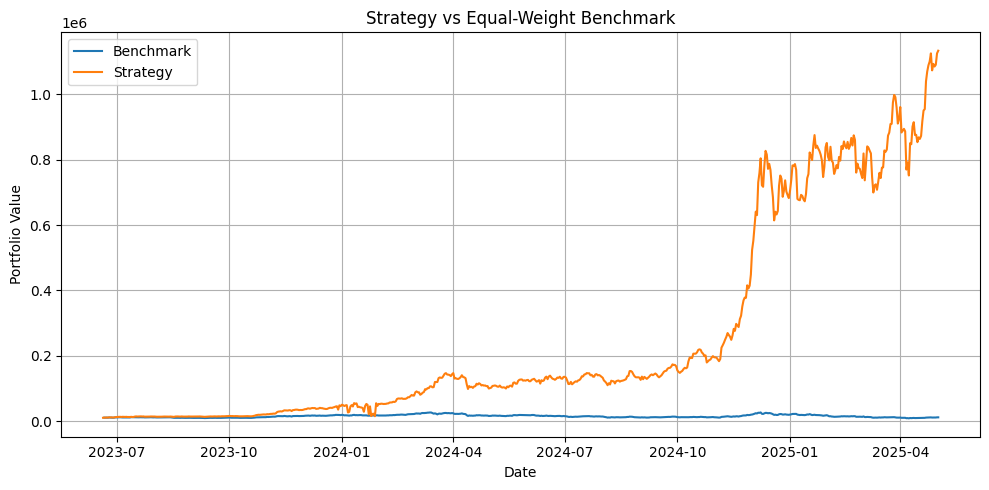

In [ ]:
# Fix column names
strategy_df = portfolio_df[['datetime', 'total_value']].copy()
strategy_df.rename(columns={'datetime': 'date', 'total_value': 'portfolio_value'}, inplace=True)
strategy_df['source'] = 'Strategy'

benchmark_df['source'] = 'Benchmark'

# Combine and plot
combined_plot_df = pd.concat([strategy_df, benchmark_df], ignore_index=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for label, group in combined_plot_df.groupby('source'):
    plt.plot(group['date'], group['portfolio_value'], label=label)

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Strategy vs Equal-Weight Benchmark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# End of Model

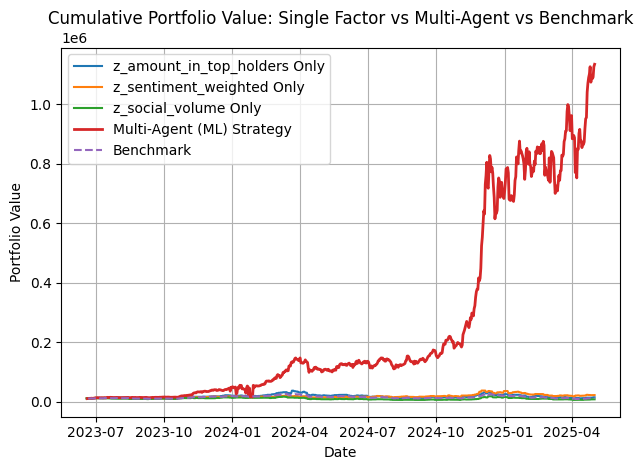

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def single_factor_strategy(df, factor, hold_period=3, initial_capital=10000, top_n=3):
    df = df.copy()
    df['date'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['date', 'token'])
    unique_dates = sorted(df['date'].unique())
    capital = initial_capital
    portfolio_values = []
    i = 0
    while i < len(unique_dates):
        date = unique_dates[i]
        # choose topN token
        day_df = df[df['date'] == date].sort_values(by=factor, ascending=False)
        top_tokens = day_df.head(top_n)['token'].tolist()
        # 计算每个token的买入价
        prices_buy = {}
        for t in top_tokens:
            prices_buy[t] = df[(df['token']==t) & (df['date']==date)]['price_usd'].values[0]
        # 等权分配资金
        invest_per_token = capital / top_n
        # 持有hold_period天，卖出
        date_sell_idx = min(i + hold_period, len(unique_dates)-1)
        date_sell = unique_dates[date_sell_idx]
        proceeds = 0
        for t in top_tokens:
            price_sell_row = df[(df['token']==t) & (df['date']==date_sell)]
            if not price_sell_row.empty:
                price_sell = price_sell_row['price_usd'].values[0]
                proceeds += invest_per_token * price_sell / prices_buy[t]
            else:
                proceeds += invest_per_token  # 若无数据按原值计
        capital = proceeds
        # 记录每个调仓点的资产
        for step in range(hold_period):
            idx = min(i + step, len(unique_dates)-1)
            portfolio_values.append({'date': unique_dates[idx], 'portfolio_value': capital})
        i += hold_period
    result_df = pd.DataFrame(portfolio_values)
    return result_df

# 用于画图
for factor in ['z_amount_in_top_holders', 'z_sentiment_weighted', 'z_social_volume']:
    strat_df = single_factor_strategy(combined_df, factor)
    plt.plot(strat_df['date'], strat_df['portfolio_value'], label=f"{factor} Only")
plt.plot(strategy_df['date'], strategy_df['portfolio_value'], label="Multi-Agent (ML) Strategy", linewidth=2)
plt.plot(benchmark_df['date'], benchmark_df['portfolio_value'], label="Benchmark", linestyle='--')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Cumulative Portfolio Value: Single Factor vs Multi-Agent vs Benchmark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Suppose benchmark_df has ['date', 'portfolio_value']
benchmark_df = benchmark_df.sort_values('date').reset_index(drop=True)
benchmark_df['ma_short'] = benchmark_df['portfolio_value'].rolling(20, min_periods=1).mean() # 20-day MA
benchmark_df['ma_long'] = benchmark_df['portfolio_value'].rolling(60, min_periods=1).mean() # 60-day MA

def classify_regime(row):
    # Only compare current MA20 vs MA60 using only historical data up to this point
    if row['ma_short'] > row['ma_long'] * 1.01:
        return 'Bull'
    elif row['ma_short'] < row['ma_long'] * 0.99:
        return 'Bear'
    else:
        return 'Sideways'

benchmark_df['regime'] = benchmark_df.apply(classify_regime, axis=1)
date_regime = dict(zip(benchmark_df['date'], benchmark_df['regime']))

# For each strategy, add the regime column by date
def add_regime(df):
    df = df.copy()
    df['regime'] = df['date'].map(date_regime)
    return df

strategy_df = add_regime(strategy_df)
benchmark_df = add_regime(benchmark_df)



In [ ]:
# Whale Only、Sentiment Only、Social Volume Only backtesting DataFrame
whale_df = single_factor_strategy(combined_df, 'z_amount_in_top_holders')
sentiment_df = single_factor_strategy(combined_df, 'z_sentiment_weighted')
social_df = single_factor_strategy(combined_df, 'z_social_volume')

# ensure DataFrame with 'regime'label
whale_df = add_regime(whale_df)
sentiment_df = add_regime(sentiment_df)
social_df = add_regime(social_df)


Performance by regime and strategy:
              strategy    regime   cum_return  max_drawdown    sharpe
0          Multi-Agent      Bull  5435.093092    -73.157251  2.077101
1            Benchmark      Bull    56.943333    -57.395569  0.919921
2           Whale Only      Bull    78.427987    -67.766663  0.996556
3       Sentiment Only      Bull   148.404689    -29.774610  1.392797
4   Social Volume Only      Bull    20.884348    -65.959298  0.622186
5          Multi-Agent      Bear  8032.630851    -25.325247  1.848910
6            Benchmark      Bear    12.212000    -61.310348  0.509420
7           Whale Only      Bear    17.324375    -54.256483  0.541854
8       Sentiment Only      Bear   118.951555    -47.382227  1.121448
9   Social Volume Only      Bear   -12.530442    -58.282964  0.323407
10         Multi-Agent  Sideways  6551.974301    -16.521302  4.125249
11           Benchmark  Sideways    80.978749    -47.100630  1.931241
12          Whale Only  Sideways   119.228775    -47.9

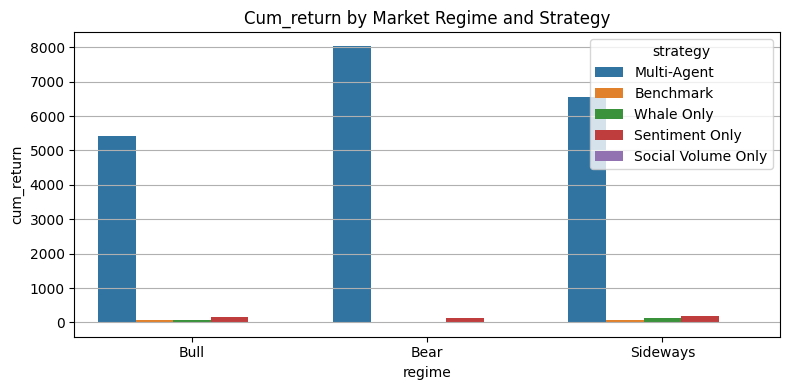

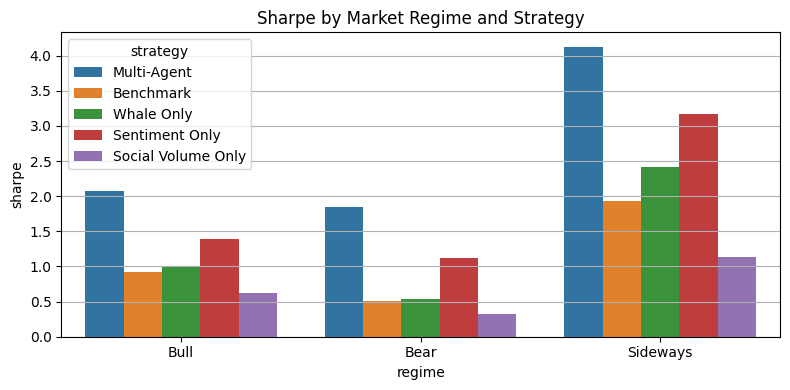

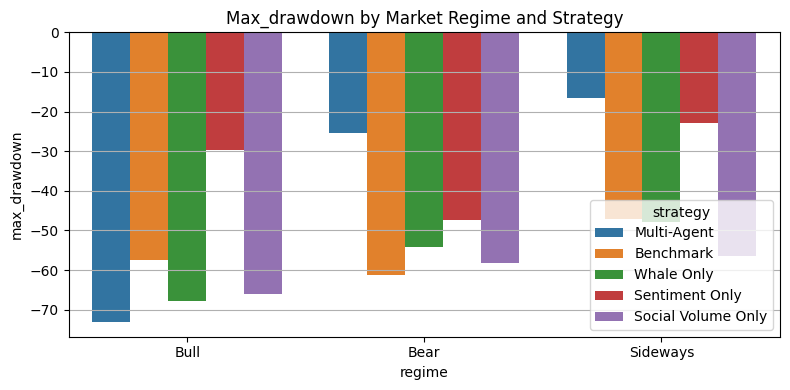

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------- STEP 1: Make sure 'regime' column has been added for each DataFrame --------

# --------- STEP 2: Prepare all strategy DataFrames ----------
# Example: suppose you have these variables ready:
# strategy_df, benchmark_df, whale_df, sentiment_df, social_df

all_dfs = [
    ('Multi-Agent', strategy_df),
    ('Benchmark', benchmark_df),
    ('Whale Only', whale_df),
    ('Sentiment Only', sentiment_df),
    ('Social Volume Only', social_df)
]

# --------- STEP 3: Compute stats per regime for each strategy ----------
def compute_stats(df, label, regime):
    # Filter by regime
    sub = df[df['regime'] == regime].copy()
    if len(sub) < 2:
        return None
    # Calculate daily return
    sub['return'] = sub['portfolio_value'].pct_change()
    cum_return = (sub['portfolio_value'].iloc[-1] / sub['portfolio_value'].iloc[0] - 1) * 100
    maxdd = ((sub['portfolio_value'] - sub['portfolio_value'].cummax()) / sub['portfolio_value'].cummax()).min() * 100
    sharpe = sub['return'].mean() / sub['return'].std() * np.sqrt(252) if sub['return'].std() > 0 else 0
    return {'strategy': label, 'regime': regime, 'cum_return': cum_return, 'max_drawdown': maxdd, 'sharpe': sharpe}

results = []
regimes = ['Bull', 'Bear', 'Sideways']

for regime in regimes:
    for label, df in all_dfs:
        stats = compute_stats(df, label, regime)
        if stats:
            results.append(stats)

results_df = pd.DataFrame(results)
print("Performance by regime and strategy:")
print(results_df)

# --------- STEP 4: Visualization (optional) ----------
for metric in ['cum_return', 'sharpe', 'max_drawdown']:
    plt.figure(figsize=(8,4))
    sns.barplot(data=results_df, x='regime', y=metric, hue='strategy')
    plt.title(f'{metric.capitalize()} by Market Regime and Strategy')
    plt.ylabel(metric)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


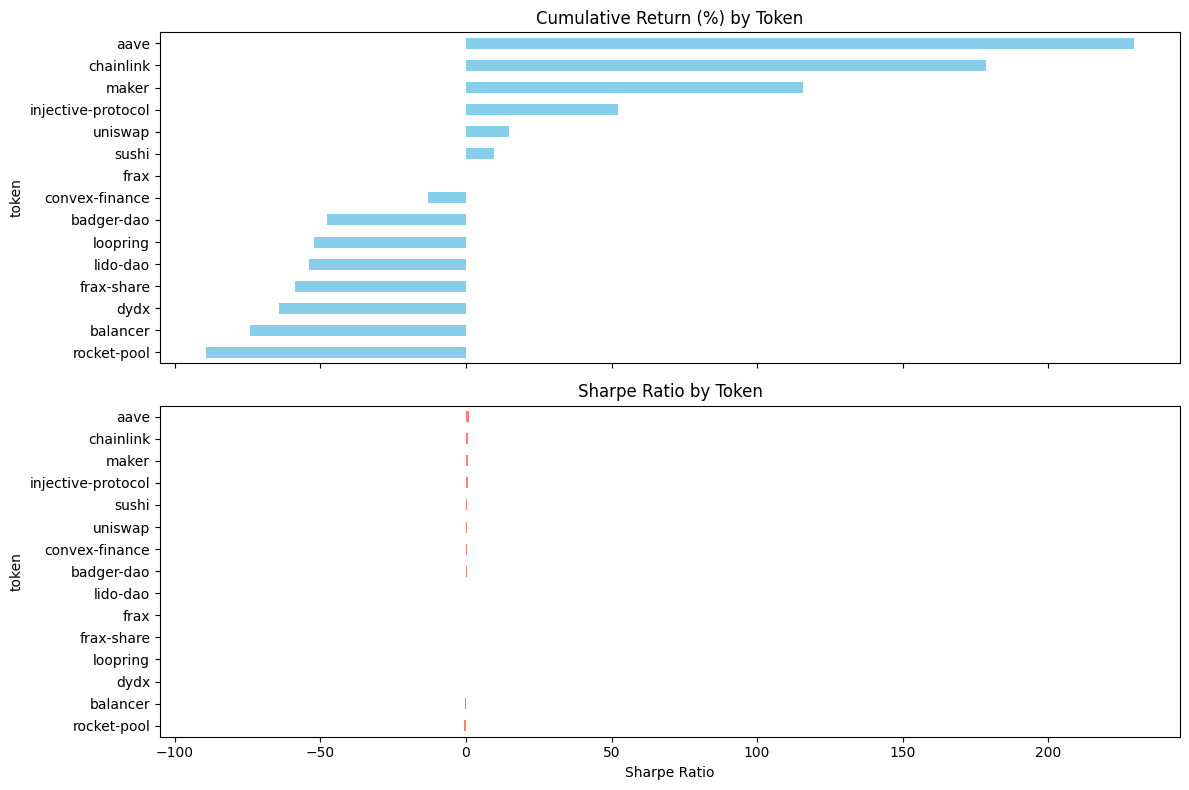

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 统计每个Token的累计收益和Sharpe
token_stats = []
for token, df in all_tokens_analysis.items():
    # 只用有price的token
    if 'price_usd' not in df.columns or df['price_usd'].isna().all():
        continue
    ret = df['price_usd'].pct_change().dropna()
    sharpe = ret.mean() / ret.std() * np.sqrt(252) if ret.std() > 0 else np.nan
    cumret = (df['price_usd'].iloc[-1] / df['price_usd'].iloc[0] - 1) * 100
    token_stats.append({'token': token, 'cum_return': cumret, 'sharpe': sharpe})

stats_df = pd.DataFrame(token_stats).set_index('token')

# 横向条形图可视化
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

stats_df['cum_return'].sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Cumulative Return (%) by Token')
axes[0].set_xlabel('Cumulative Return (%)')

stats_df['sharpe'].sort_values().plot(kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('Sharpe Ratio by Token')
axes[1].set_xlabel('Sharpe Ratio')

plt.tight_layout()
plt.show()



**Token-level Cumulative Return and Sharpe Ratio Bar Chart**


In [ ]:
print(combined_df.columns)


Index(['datetime', 'price_usd', 'social_volume_total',
       'sentiment_weighted_total', 'sentiment_positive_total',
       'sentiment_negative_total', 'sentiment_balance_total', 'dev_activity',
       'amount_in_top_holders', 'whale_tx_count', 'whale_tx_volume', 'return',
       'future_return_1d', 'rolling_return_7d', 'rolling_avg',
       'z_social_volume', 'z_sentiment_weighted', 'z_dev_activity',
       'z_amount_in_top_holders', 'z_whale_tx_count', 'z_whale_tx_volume',
       'delta_top_holders', 'sentiment_x_volume', 'signal', 'anomaly_social',
       'anomaly_sentiment', 'anomaly_whale_volume', 'anomaly_whale_count',
       'token', 'is_held'],
      dtype='object')


In [ ]:
combined_df = combined_df.rename(columns={'datetime': 'date'})
combined_df['date'] = pd.to_datetime(combined_df['date'])


In [ ]:
combined_df['is_held'] = 0
for idx, row in daily_top.iterrows():
    token = row['token']
    date = row['date']
    for k in range(hold_period):
        hold_date = date + pd.Timedelta(days=k)
        mask = (combined_df['token'] == token) & (combined_df['date'] == hold_date)
        combined_df.loc[mask, 'is_held'] = 1


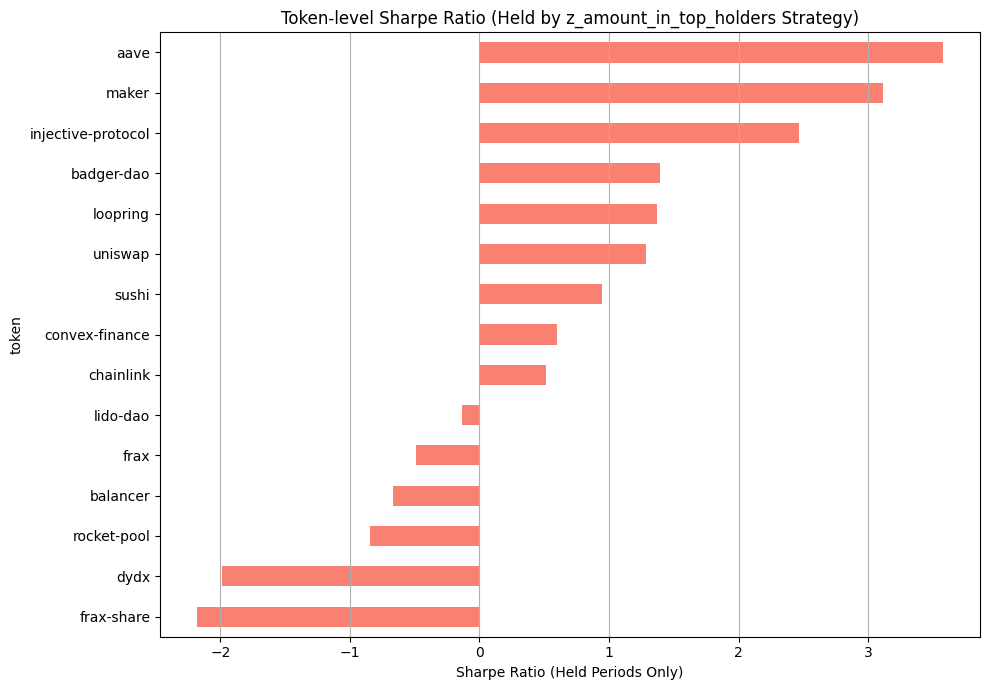

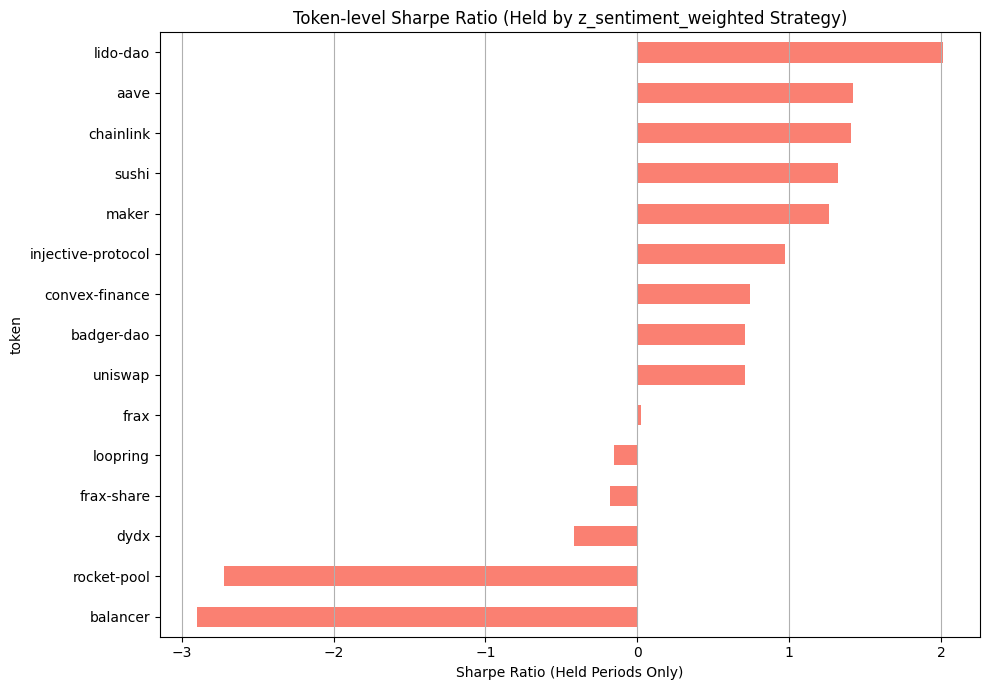

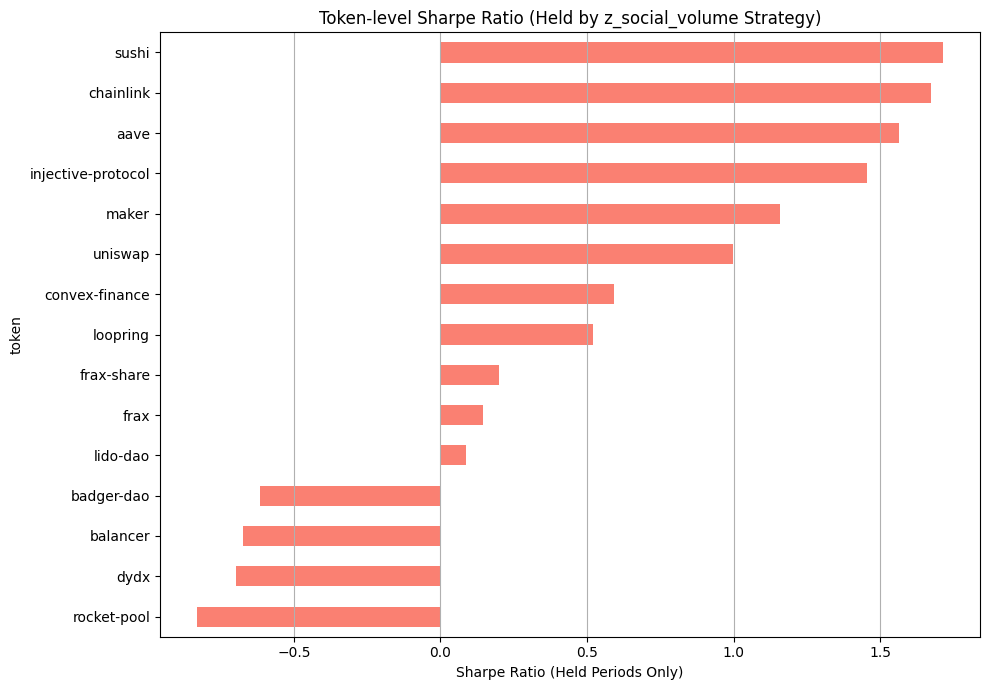

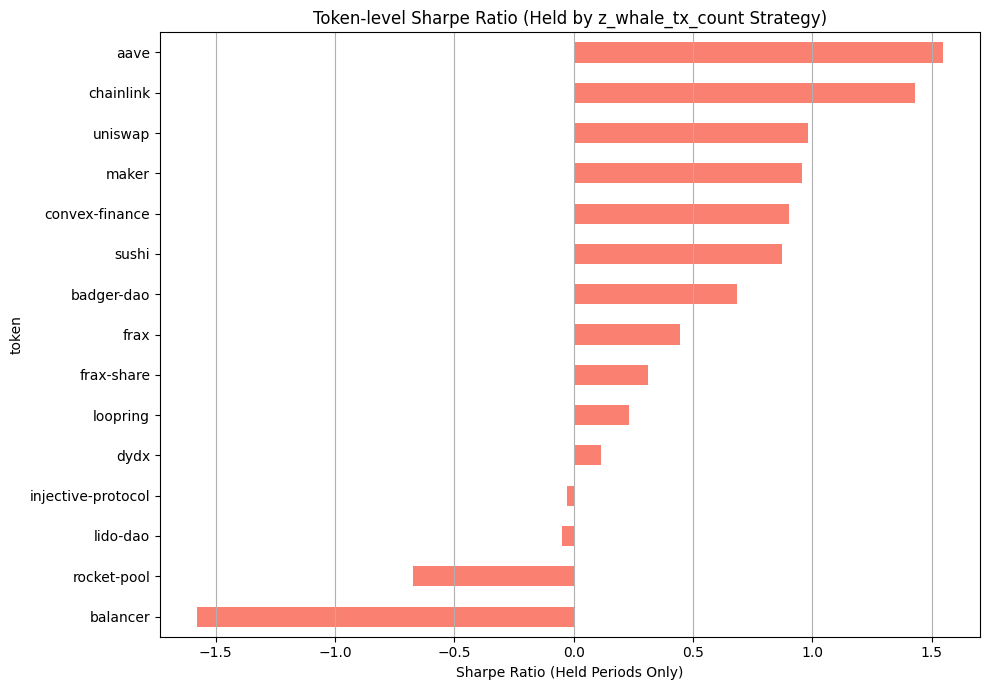

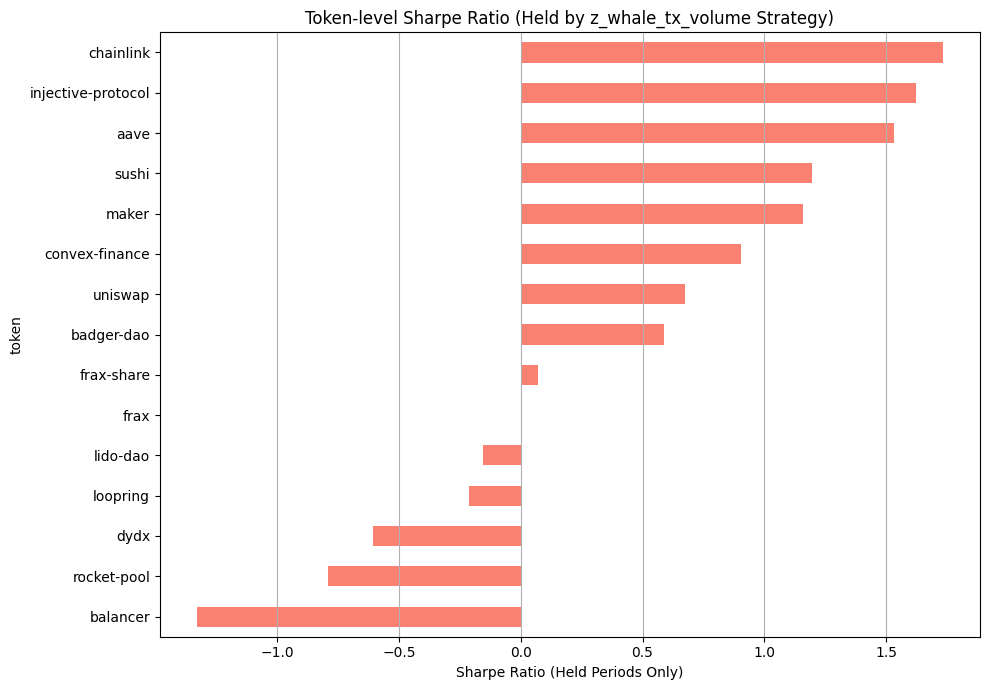

In [ ]:
import matplotlib.pyplot as plt

factors = ['z_amount_in_top_holders', 'z_sentiment_weighted', 'z_social_volume', 'z_whale_tx_count',
            'z_whale_tx_volume']  # 可以补充更多
top_n = 3
hold_period = 3

for factor in factors:
    # 1. 重新构建 daily_top
    unique_dates = sorted(combined_df['date'].unique())
    daily_top = []
    i = 0
    while i < len(unique_dates):
        date = unique_dates[i]
        day_df = combined_df[combined_df['date'] == date].sort_values(by=factor, ascending=False)
        top_tokens = day_df.head(top_n)['token'].tolist()
        for token in top_tokens:
            daily_top.append({'date': date, 'token': token})
        i += hold_period
    daily_top = pd.DataFrame(daily_top)

    # 2. 标记 is_held
    combined_df['is_held'] = 0
    for idx, row in daily_top.iterrows():
        token = row['token']
        date = row['date']
        for k in range(hold_period):
            hold_date = date + pd.Timedelta(days=k)
            mask = (combined_df['token'] == token) & (combined_df['date'] == hold_date)
            combined_df.loc[mask, 'is_held'] = 1

    # 3. 统计 Sharpe
    token_stats = []
    for token in combined_df['token'].unique():
        df = combined_df[(combined_df['token'] == token) & (combined_df['is_held'] == 1)].sort_values('date')
        if df.shape[0] < 2:
            continue
        ret = df['price_usd'].pct_change().dropna()
        sharpe = ret.mean() / ret.std() * np.sqrt(252) if ret.std() > 0 else np.nan
        cumret = (df['price_usd'].iloc[-1] / df['price_usd'].iloc[0] - 1) * 100
        token_stats.append({'token': token, 'cum_return': cumret, 'sharpe': sharpe})
    stats_df = pd.DataFrame(token_stats).set_index('token').sort_values('sharpe')

    # 4. 可视化
    plt.figure(figsize=(10, 7))
    stats_df['sharpe'].plot(kind='barh', color='salmon')
    plt.xlabel('Sharpe Ratio (Held Periods Only)')
    plt.title(f'Token-level Sharpe Ratio (Held by {factor} Strategy)')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()


In [ ]:
features = [
    'social_volume_total', 'price_usd', 'return', 'rolling_avg',
    'sentiment_weighted_total', 'z_amount_in_top_holders',
    'delta_top_holders', 'z_social_volume', 'z_sentiment_weighted',
    'sentiment_lag1', 'price_lag1', 'z_whale_tx_count', 'z_whale_tx_volume'
]

for token, df in all_tokens_analysis.items():
    # 新增这行，强制所有token有所有features，没有的补0
    df = df.reindex(columns=features, fill_value=0)
    all_tokens_analysis[token] = df


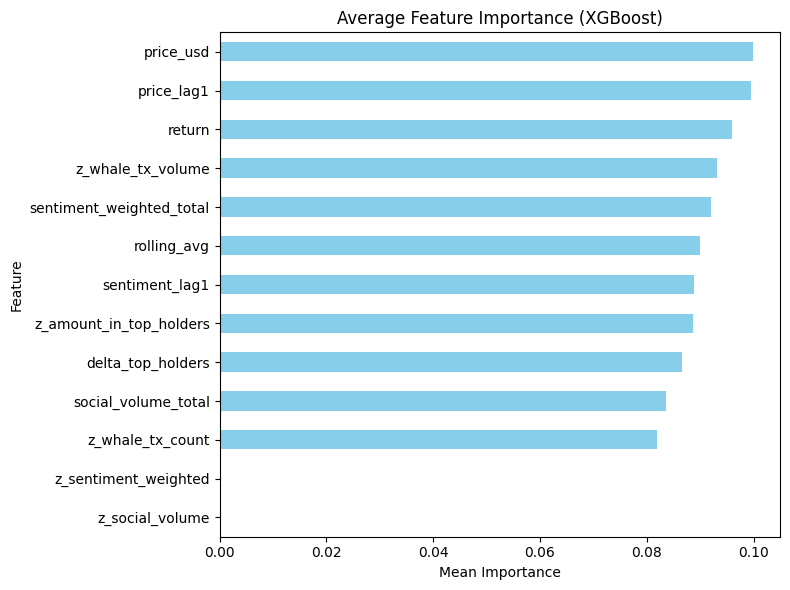

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = []
for token in all_models.keys():
    model = all_models[token]
    fscore = model.feature_importances_
    for i, feat in enumerate(features):   # features为你模型的特征名list
        importances.append({'token': token, 'feature': feat, 'importance': fscore[i]})

imp_df = pd.DataFrame(importances)
# 计算每个特征在所有token上的平均重要性
imp_pivot = imp_df.pivot_table(index='feature', values='importance', aggfunc='mean')
imp_pivot.sort_values('importance').plot(kind='barh', figsize=(8,6), legend=False, color='skyblue')
plt.title('Average Feature Importance (XGBoost)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
for token, combined_df in all_tokens_data.items():
    print(token, combined_df.columns)


aave Index(['datetime', 'price_usd', 'social_volume_total',
       'sentiment_weighted_total', 'sentiment_positive_total',
       'sentiment_negative_total', 'sentiment_balance_total', 'dev_activity',
       'amount_in_top_holders', 'whale_tx_count', 'whale_tx_volume', 'return',
       'future_return_1d', 'rolling_return_7d', 'rolling_avg',
       'z_social_volume', 'z_sentiment_weighted', 'z_dev_activity',
       'z_amount_in_top_holders', 'z_whale_tx_count', 'z_whale_tx_volume',
       'delta_top_holders', 'sentiment_x_volume', 'signal', 'anomaly_social',
       'anomaly_sentiment', 'anomaly_whale_volume', 'anomaly_whale_count',
       'sentiment_lag1', 'dev_activity_lag1', 'price_lag1',
       'predicted_buy_signal'],
      dtype='object')
uniswap Index(['datetime', 'price_usd', 'social_volume_total',
       'sentiment_weighted_total', 'sentiment_positive_total',
       'sentiment_negative_total', 'sentiment_balance_total', 'dev_activity',
       'amount_in_top_holders', 'whale_tx_c

In [ ]:
for token, df in all_tokens_data.items():
    print(f"{token} z_social_volume: mean={df['z_social_volume'].mean()}, std={df['z_social_volume'].std()}, min={df['z_social_volume'].min()}, max={df['z_social_volume'].max()}")
    print(f"{token} z_sentiment_weighted: mean={df['z_sentiment_weighted'].mean()}, std={df['z_sentiment_weighted'].std()}, min={df['z_sentiment_weighted'].min()}, max={df['z_sentiment_weighted'].max()}")
    break  # 先看一个token输出，确认情况再说


aave z_social_volume: mean=0.0042115030210014654, std=1.0033510671986798, min=-1.2002267851327741, max=8.580255698505342
aave z_sentiment_weighted: mean=0.0023735097089809796, std=1.0026920643836388, min=-5.292664747324171, max=15.979355317296442


In [ ]:
corr = df[['z_social_volume', 'social_volume_total', 'sentiment_weighted_total', 'z_sentiment_weighted']].corr()
print(corr)


                          z_social_volume  social_volume_total  \
z_social_volume                  1.000000             1.000000   
social_volume_total              1.000000             1.000000   
sentiment_weighted_total         0.046231             0.046231   
z_sentiment_weighted             0.046231             0.046231   

                          sentiment_weighted_total  z_sentiment_weighted  
z_social_volume                           0.046231              0.046231  
social_volume_total                       0.046231              0.046231  
sentiment_weighted_total                  1.000000              1.000000  
z_sentiment_weighted                      1.000000              1.000000  


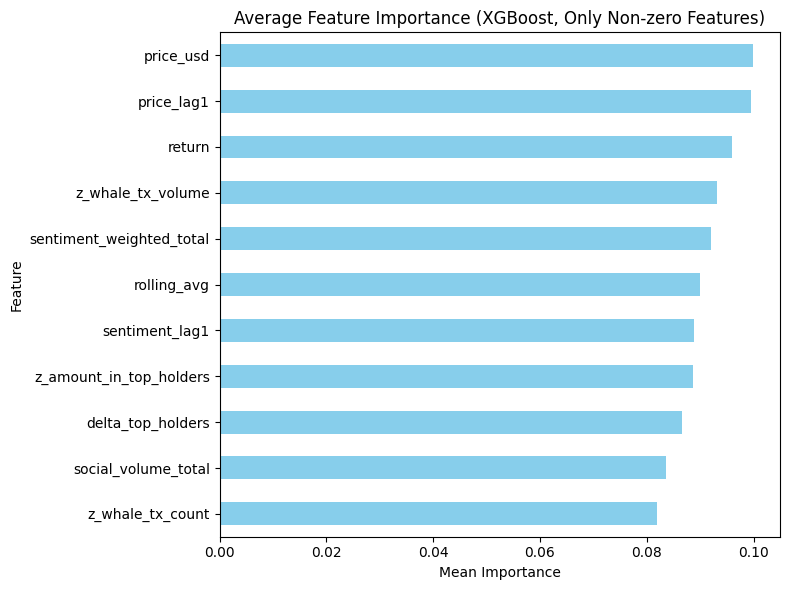

In [ ]:
imp_pivot = imp_df.pivot_table(index='feature', values='importance', aggfunc='mean', fill_value=0)
# 筛掉均值为0的特征
imp_pivot = imp_pivot[imp_pivot['importance'] > 0]
imp_pivot.sort_values('importance').plot(kind='barh', figsize=(8,6), legend=False, color='skyblue')
plt.title('Average Feature Importance (XGBoost, Only Non-zero Features)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
